# test of all code in `stancode_gallery1` for count data
 * using code from `/experimental/experimental_zinser_seaflow_20200518_modelfit_clone2_truecounts.ipynb` to compute counts
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser
import sys

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

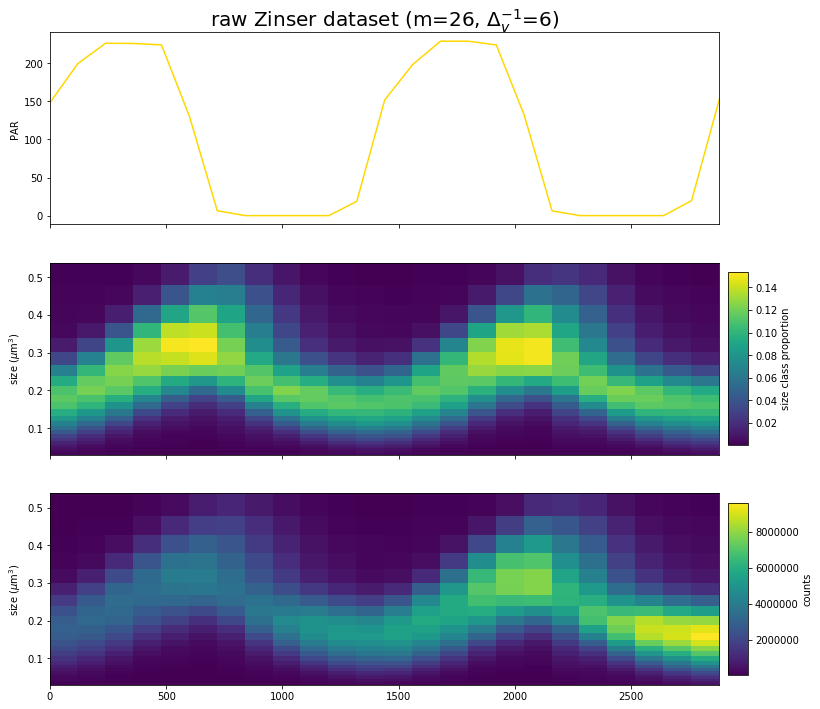

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 3
    sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])
    
    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))
    
    ax = axs[0]
    ax.set_title('raw '+desc[dataname], size=20)
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

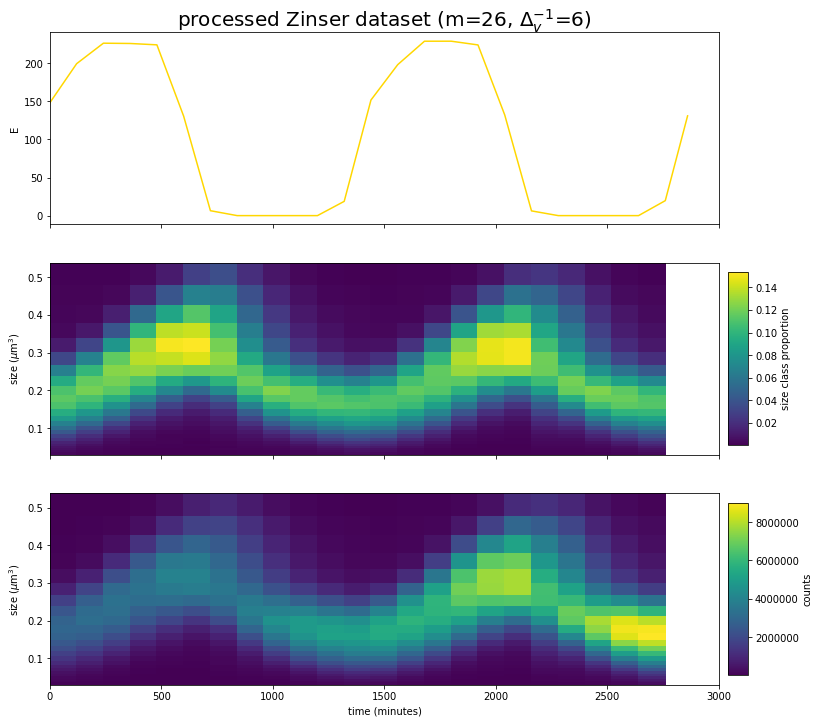

In [4]:
for i,dataname in enumerate(data):
    nrows = 3
    
    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    
    
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    
    ax = axs[0]
    ax.set_title('processed '+desc[dataname], size=20)
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)

    ax = axs[2]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    's1':'m1',
    's2':'m2',
    's3':'m3',
    's4':'m4',
    's5':'m5',
    's6':'m6',
    's7':'m7',
    's8':'m8',
    's9':'m9',
    #'s10':'m10',
    's11':'m5 + size-dep growth (m5-m6 hybrid)',
    #'s12':'m5 + size-dep growth (m5-m7 hybrid)',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
    's11':(),
    's12':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
    's11':'c56',
    's12':'c57',
}
stan_files = {
    'c1':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
    'c2':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
    'c3':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
    'c4':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
    'c5':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c6':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
    'c7':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
    'c8':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
    'c9':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',
    'c10':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_resp_gammaiv6_normparam_trackgrowth_xval.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_resp_gammaiv7_normparam_trackgrowth_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

/home/paul/.local/lib/python3.6/site-packages/Cython/Distutils/old_build_ext.py:41: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "
INFO:pystan:COMPILING THE C++ CODE FOR MODEL s1 NOW.


s1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s2 NOW.


s2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s4 NOW.


s4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s8 NOW.


s8: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s11 NOW.


s11: compiling


In [6]:
import time
refit_all = False

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in meanrhats:
        meanrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in meanrhats[name]:
            meanrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1: in try 1/3 found Rhat=1.166, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1: in try 2/3 found Rhat=1.553, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1: in try 3/3 found Rhat=1.555, trying again
s1 (m1)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.89    0.05   0.45   2.15    2.6   2.84   3.16   3.92     67   1.02
delta_sigma         1.86    0.06   0.43    1.2   1.55   1.79   2.11    2.9     56   1.08
delta_max[1]      1.7e-3  2.9e-4 1.0e-3 5.7e-4 9.5e-4 1.4e-3 2.0e-3 4.7e-3     12   1.51
delta_max[2]         0.3  7.1e-3   0.05   0.22   0.27    0.3   0.33    0.4     41   1.09
delta_max[3]        0.93    0.01    0.1   0.75   0.86   0.92   0.99   1.14     93   1.03
delta_max[4]        1.41    0.02   0.16   1.13    1.3    1.4   1.51   1.74     54   1.04
delta_max[5]        1.54    0.02   0.15   1.26   1.43   1.54   1.65   1.85     89   1.02
delta_max[6]         2.1    0.02    0.2   1.71   1.96   2.12   2.24   2.47     65   1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s1 (m1)
Inference for Stan model: s1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.78  9.3e-3    0.6    1.6   2.37   2.78   3.17   3.97   4102    1.0
delta_sigma          3.4  9.7e-3   0.59   2.42   2.99   3.34   3.73   4.82   3731    1.0
delta_max[1]        3.37    0.02   0.99   1.74   2.68   3.28   3.96   5.57   3395    1.0
delta_max[2]        0.78  6.2e-3   0.38   0.21   0.52   0.73   0.99   1.68   3692    1.0
delta_max[3]        0.64  4.0e-3   0.27    0.2   0.44    0.6   0.79   1.27   4642    1.0
delta_max[4]        0.56  3.4e-3   0.23   0.18   0.39   0.53   0.69   1.07   4485    1.0
delta_max[5]        0.49  2.7e-3   0.19   0.17   0.36   0.47   0.61    0.9   4766    1.0
delta_max[6]        0.47  2.1e-3   0.16   0.19   0.36   0.45   0.57   0.81   5566    1.0
delta_max[7]        0.28  1.8e-3   0.11   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 1/3 found Rhat=1.314, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 2/3 found Rhat=2.102, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2: in try 3/3 found Rhat=1.228, trying again
s2 (m2)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.13    0.05    0.5   1.26   1.78   2.07   2.42   3.25    114   1.06
gamma_max            1.32    0.04    0.2   1.12   1.21   1.28   1.35   2.09     20   1.18
E_star             208.48   94.73  379.8   0.97  29.17  72.67 184.65 1677.3     16   1.23
sigma              461.31    4.21  33.23  398.2 438.42 462.62 484.77  522.7     62   1.08
divrate              0.65  6.0e-3   0.04   0.57   0.62   0.65   0.67   0.72     39   1.09
delta_max[1]       1.2e-3  1.5e-4 6.9e-4 3.3e-4 7.8e-4 1.1e-3 1.5e-3 3.0e-3     20   1.15
delta_max[2]         0.31  5.6e-3   0.05   0.23   0.28   0.31   0.34   0.41     67   1.03
delta_max[3]         0.98    0.01    0.1    0.8   0.91   0.97   1.04   1.18   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s2 (m2)
Inference for Stan model: s2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.26  3.5e-3    0.3   0.74   1.05   1.23   1.45   1.92   7165    1.0
gamma_max            5.29    0.04   1.56   3.56   4.14   4.73   6.01   9.36   1675    1.0
E_star             184.22    2.58 106.04  61.06 104.23 149.73 239.04 457.58   1695    1.0
sigma              143.34    0.16  12.17 120.83 134.91 142.85 151.28 168.02   6145    1.0
divrate              1.58  1.5e-3   0.09    1.4   1.51   1.57   1.64   1.76   3684    1.0
delta_max[1]          0.5  8.7e-4   0.05    0.4   0.47    0.5   0.54   0.61   3978    1.0
delta_max[2]         0.53  8.0e-4   0.05   0.44    0.5   0.53   0.57   0.64   4014    1.0
delta_max[3]         0.56  7.9e-4   0.05   0.46   0.52   0.55   0.59   0.66   4009    1.0
delta_max[4]         0.57  7.9e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=224.374, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 2/3 found Rhat=73.053, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 3/3 found Rhat=187.415, trying again
s3 (m3)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.21    1.02   1.44   0.25   0.78   2.29   3.66   3.88      2  37.49
gamma_max             5.8    0.76   1.24   2.72    5.4   5.82   6.71   7.53      3    4.7
xi                 2.1e-3  2.1e-3 3.7e-3-1.1e-4-9.6e-6 5.5e-5 1.6e-3   0.01      3   3.96
E_star             1099.6  233.13 415.21 521.76 794.92  972.9 1648.5 1759.8      3   3.33
sigma               42.31   37.11   58.3   2.02   9.06  12.39  28.32 179.91      2   3.81
divrate              1.14    0.11   0.25   0.57   0.95   1.18   1.36   1.58      6   2.55
delta_max[1]         0.44    0.17   0.24    0.2   0.22    0.3   0.73   0.81      2   9.43
delta_max[2]         1.48    0.41   0.61   0.57   0.88   1.57   1.94   2.55 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m3)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          1.3  3.5e-3   0.32   0.77   1.08   1.26   1.49    2.0   8199    1.0
gamma_max            5.71    0.04   1.62   3.78   4.44   5.21   6.62   9.52   1666    1.0
xi                  -0.23  1.2e-3    0.1  -0.43   -0.3  -0.23  -0.16  -0.03   7319    1.0
E_star             197.84    2.54 104.07  67.67  116.6 168.89  261.0 439.57   1676    1.0
sigma              147.29    0.16  12.47 123.15 138.89 147.14 155.73 172.32   6023    1.0
divrate              1.56  1.5e-3   0.09   1.39    1.5   1.56   1.61   1.74   3497    1.0
delta_max[1]         0.51  8.7e-4   0.05    0.4   0.47   0.51   0.55   0.62   3882    1.0
delta_max[2]         0.54  7.9e-4   0.05   0.45   0.51   0.54   0.57   0.64   3832    1.0
delta_max[3]         0.56  7.9e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4: in try 1/3 found Rhat=1.166, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4: in try 2/3 found Rhat=1.145, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4: in try 3/3 found Rhat=1.117, trying again
s4 (m4)
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.27    0.06    0.5   1.45   1.92   2.21   2.57   3.36     73   1.08
gamma_max            1.29    0.01   0.09   1.11   1.23   1.29   1.35   1.48     49    1.1
rho_max            1.7e-3  1.5e-4 1.5e-3 6.4e-5 6.4e-4 1.3e-3 2.4e-3 5.6e-3    106   1.04
E_star             127.74   16.06 150.68   0.64  34.16   77.2 165.59 569.27     88   1.04
sigma              461.74    3.65   34.8 401.61 436.52 460.23 483.38 534.49     91   1.04
divrate              0.65  3.2e-3   0.03   0.59   0.63   0.65   0.67   0.72    114   1.03
delta_max[1]       1.6e-3  1.2e-4 9.2e-4 2.2e-4 9.5e-4 1.5e-3 2.1e-3 3.8e-3     59   1.06
delta_max[2]         0.32  5.5e-3   0.05   0.23   0.28   0.32   0.35   0.41   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s4 (m4)
Inference for Stan model: s4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.83  7.1e-3   0.45   1.05   1.52   1.79   2.12   2.82   4053    1.0
gamma_max            4.74    0.02   0.57   4.08   4.39   4.61   4.91   6.34   1048    1.0
rho_max              1.05  2.3e-3   0.11   0.83   0.98   1.05   1.13   1.26   2370    1.0
E_star              95.63    1.24  40.56  47.92  68.53  85.74 110.48 204.71   1078    1.0
sigma               186.2    0.27  16.09 156.75  175.2 186.02 196.63 218.11   3467    1.0
divrate              0.87  1.4e-3   0.09   0.71   0.81   0.87   0.92   1.05   3581    1.0
delta_max[1]         0.17  8.3e-4   0.04   0.09   0.14   0.17    0.2   0.26   2739    1.0
delta_max[2]          0.2  6.4e-4   0.04   0.12   0.17    0.2   0.22   0.28   3634    1.0
delta_max[3]         0.21  6.3e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5: in try 1/3 found Rhat=1.428, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5: in try 2/3 found Rhat=1.311, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5: in try 3/3 found Rhat=1.730, trying again
s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.05    0.15   0.53   1.16   1.62   2.06   2.44   3.09     12   1.24
gamma_max            1.36    0.09   0.27   1.08   1.21   1.28    1.4   2.27      9   1.51
rho_max            1.5e-3  3.5e-4 1.6e-3 1.8e-5 2.3e-4 8.4e-4 2.3e-3 5.8e-3     23   1.15
E_star             335.25  182.12 503.15   0.92  20.31  72.74 543.84 1882.9      8   1.57
sigma              455.14    7.03  27.94 404.54 435.99 455.56 474.17 513.36     16   1.22
divrate              0.63  9.3e-3   0.04   0.55   0.61   0.63   0.66   0.71     18   1.21
delta_max[1]       1.7e-3  3.8e-4 9.4e-4 3.3e-4 1.1e-3 1.5e-3 2.4e-3 3.9e-3      6   1.36
delta_max[2]          0.3    0.02   0.06    0.2   0.26   0.29   0.33   0.44   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.02  6.9e-3   0.48   1.21   1.67   1.97   2.31   3.09   4921    1.0
gamma_max            3.85  3.4e-3   0.15   3.58   3.75   3.83   3.93   4.21   2050    1.0
rho_max              1.32  1.8e-3   0.09   1.13   1.26   1.32   1.38    1.5   2716    1.0
E_star              54.45    0.37  15.32  32.51  44.02  51.65  61.54  92.82   1750    1.0
sigma              246.62    0.35   21.5  205.8  232.2 245.85 260.63 290.88   3739    1.0
divrate              0.74  1.1e-3   0.07   0.62    0.7   0.74   0.79   0.88   3875    1.0
delta_max[1]         0.19  4.5e-4   0.03   0.14   0.17   0.19   0.21   0.25   3712    1.0
delta_max[2]          0.2  3.9e-4   0.03   0.16   0.19    0.2   0.22   0.26   4402    1.0
delta_max[3]         0.21  3.8e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6: in try 1/3 found Rhat=281.246, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6: in try 2/3 found Rhat=161.967, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6: in try 3/3 found Rhat=349.390, trying again
s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.93     0.9   1.28   0.27   0.95   1.78   2.85   4.05      2  37.74
gamma_max             5.6    1.14    1.7   3.06   3.79   6.14   7.34   7.72      2   8.02
xi                -1.5e-5  1.0e-6 4.8e-5-1.3e-4-3.5e-5-8.1e-6 9.3e-6 7.2e-5   2327   1.01
xir                 -0.41    0.08   0.14  -0.73   -0.5  -0.39  -0.31  -0.22      3   2.77
rho_max              0.41    0.19   0.27   0.17   0.18   0.31   0.62   0.88      2   46.1
E_star             2628.2  798.39 1135.7 1250.7 1455.5 2536.2 3780.7 4233.2      2   22.4
sigma                9.71    4.14   9.52   1.36   2.29   5.75  12.73  37.11      5   3.55
divrate              0.73    0.09   0.18   0.38   0.55   0.76   0.91   0.97 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          2.6  9.4e-3    0.6   1.55   2.19   2.56   2.97   3.89   4124    1.0
gamma_max             4.5  8.3e-3   0.27    4.1   4.33   4.46   4.63   5.11   1020    1.0
xi                  -0.62  2.1e-3   0.11  -0.83   -0.7  -0.63  -0.55  -0.41   2611    1.0
xir                  0.17  1.8e-3    0.1  -0.02    0.1   0.17   0.23   0.36   3102    1.0
rho_max              1.49  2.2e-3    0.1    1.3   1.42   1.49   1.56    1.7   2148    1.0
E_star              69.71     0.6  19.97  41.42  55.75  66.38  79.64 115.08   1091    1.0
sigma              321.22    0.64  30.66 264.68 299.18 319.85 341.05 385.53   2309    1.0
divrate              0.62  8.8e-4   0.05   0.53   0.59   0.62   0.66   0.72   3179    1.0
delta_max[1]         0.19  4.0e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7: in try 1/3 found Rhat=709.465, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7: in try 2/3 found Rhat=336.267, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7: in try 3/3 found Rhat=826.868, trying again
s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.51     0.6   0.88   0.22   0.59   1.32   2.19   3.09      2   3.27
gamma_max            4.28    1.88   2.69   1.21   2.48   3.46   6.85   8.63      2  17.13
xi                 5.6e-4  7.3e-4 1.6e-3-3.2e-3-4.2e-5 4.1e-6 2.3e-3 3.1e-3      5   1.39
xir                  0.05     0.2   0.28  -0.51  -0.17   0.18   0.25    0.4      2   6.29
rho_max               0.6    0.44   0.63 5.0e-3   0.16    0.5   1.11   1.67      2  19.38
E_star             1684.6  830.67 1179.0  10.24 933.56 2335.6 2821.9 2883.6      2  11.98
sigma              125.15  136.81  194.1    2.6   3.59  20.09 220.74 499.59      2  13.03
divrate              0.93    0.52   0.74   0.28   0.42   0.61   1.51    2.2 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.99  8.7e-3   0.48   1.17   1.65   1.95   2.28   3.08   3081    1.0
gamma_max            5.38    0.04   0.95    4.4   4.79   5.09   5.59    8.4    490    1.0
xi                  -0.34  1.7e-3    0.1  -0.54  -0.41  -0.34  -0.26  -0.14   3629    1.0
xir                  0.06  1.7e-3    0.1  -0.14-9.9e-3   0.06   0.13   0.25   3606    1.0
rho_max              1.11  2.6e-3   0.11   0.88   1.03   1.11   1.19   1.33   1886    1.0
E_star             115.26    2.52  58.04   52.6  76.73   98.2 133.91 293.27    531    1.0
sigma              200.57    0.33  17.27 167.68 188.67 200.01 212.21 235.34   2758    1.0
divrate              0.82  1.4e-3   0.08   0.68   0.76   0.81   0.87   0.98   3293    1.0
delta_max[1]         0.17  7.7e-4 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8: in try 1/3 found Rhat=665.559, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8: in try 2/3 found Rhat=559.024, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8: in try 3/3 found Rhat=2.171, trying again
s8 (m8)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.86     0.1   0.67   1.71   2.37   2.81   3.29   4.28     47   1.07
delta_lightthresh   11.62    0.62   7.63   0.71   5.69  10.48   16.4  29.07    153   1.03
delta_lightsigma      0.2  1.6e-3   0.02   0.16   0.18    0.2   0.21   0.24    191   1.01
gamma_max            0.76    0.05   0.29   0.46   0.57   0.67   0.88   1.59     35   1.09
xi                -5.6e-3  1.1e-3   0.01  -0.01-8.7e-3-6.5e-3-4.4e-3 3.3e-4    148   1.02
xir                  0.08  4.4e-3   0.06   0.02   0.05   0.07    0.1   0.24    162   1.03
rho_max              0.09  7.4e-3   0.07 3.5e-3   0.04   0.08   0.13   0.26     86   1.03
E_star             1046.7  187.46 895.43  38.71  355.5 812.15 1508.0 3586.1   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s8 (m8)
Inference for Stan model: s8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.71    0.01   0.62   1.62   2.27   2.69   3.11   4.04   2107    1.0
delta_lightthresh   30.06    0.62   8.57  14.78  23.93  29.35   35.6  48.55    194   1.01
delta_lightsigma     0.21  4.2e-4   0.02   0.17   0.19   0.21   0.22   0.25   2262    1.0
gamma_max            7.19     0.1   1.93   3.43   5.64   7.51   8.83   9.87    358    1.0
xi                  -0.37  2.0e-3    0.1  -0.56  -0.43  -0.37  -0.31  -0.17   2390    1.0
xir                  0.16  1.7e-3    0.1  -0.04    0.1   0.16   0.22   0.36   3413    1.0
rho_max              0.69  3.9e-3   0.11   0.46   0.62   0.69   0.77    0.9    815    1.0
E_star             558.39   10.91 194.48 192.63 407.53 579.53 709.01 882.43    318    1.0
sigma               98.32    0.46 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9: in try 1/3 found Rhat=214.378, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9: in try 2/3 found Rhat=304.542, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9: in try 3/3 found Rhat=1.854, trying again
s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.93    0.06   0.64   1.86   2.47   2.86   3.32    4.3    109   1.05
delta_lightthresh   11.35     0.7    8.0   0.95    4.6   9.47   16.9  29.09    130   1.02
delta_lightsigma      0.2  1.2e-3   0.02   0.16   0.19    0.2   0.21   0.24    274   1.01
gamma_max            0.74    0.02    0.2   0.47   0.58   0.69   0.87    1.2    131   1.02
xi                -6.0e-3  4.2e-4 3.3e-3  -0.01-8.1e-3-5.9e-3-3.7e-3-8.3e-5     61   1.05
xir                  0.06  2.8e-3   0.03   0.02   0.04   0.05   0.06   0.15    142   1.06
rho_max              0.15    0.03   0.11   0.01   0.06   0.11   0.21   0.39     13   1.24
E_star             954.82   69.17 713.03  45.96 337.35  804.2 1464.4 2448.9   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.67  8.9e-3   0.63    1.6   2.23   2.62   3.05   4.06   5039    1.0
delta_lightthresh   19.09    0.18   8.75   2.74  12.89  19.37  24.89  36.77   2399    1.0
delta_lightsigma      0.2  3.1e-4   0.02   0.16   0.19    0.2   0.22   0.24   4448    1.0
gamma_max            7.77    0.04   1.53    4.4   6.67   7.99   9.06   9.91   1411   1.01
xi                   -0.5  1.7e-3    0.1   -0.7  -0.57   -0.5  -0.43   -0.3   3690    1.0
xir                   0.2  1.7e-3    0.1 7.7e-3   0.13    0.2   0.27   0.39   3278    1.0
rho_max              1.04  2.3e-3   0.11   0.83   0.96   1.04   1.12   1.27   2312    1.0
E_star              399.0    2.99  111.1 164.29 319.58 409.95 483.29 584.47   1378   1.01
sigma              125.47    0.29 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11: in try 1/3 found Rhat=178.425, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11: in try 2/3 found Rhat=314.580, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11: in try 3/3 found Rhat=440.735, trying again
s11 (m5 + size-dep growth (m5-m6 hybrid))
Inference for Stan model: s11.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.32    0.91   1.28   0.14   0.32   0.85    2.4   3.47      2 166.29
gamma_max            5.48     0.9   1.44   3.63    4.5   5.02    5.5   8.64      3   3.72
xi                 8.5e-4  1.0e-3 1.7e-3-1.4e-4-3.1e-5-1.3e-7 5.8e-5 5.0e-3      3   3.47
rho_max              0.24    0.07    0.1   0.13   0.15   0.21   0.34    0.4      2  26.22
E_star             1894.0  925.26 1313.4 616.75 623.72 1490.0 3365.6 3642.4      2  27.81
sigma               13.69    7.82  14.68   0.22   0.31   6.41  24.37  46.39      4   4.25
divrate              0.84    0.37   0.53   0.23   0.29   0.71   1.36   1.44      2  13.07
delta_max[1]         0.71    0.38   0.54

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11 (m5 + size-dep growth (m5-m6 hybrid))
Inference for Stan model: s11.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda          2.5  8.7e-3   0.58    1.5    2.1   2.44   2.86    3.8   4450    1.0
gamma_max            4.47  8.0e-3   0.26   4.09   4.31   4.44   4.59   5.08   1051    1.0
xi                  -0.61  2.0e-3    0.1  -0.81  -0.68  -0.61  -0.54   -0.4   2779    1.0
rho_max               1.4  1.6e-3   0.08   1.24   1.34    1.4   1.45   1.55   2424    1.0
E_star              68.73    0.56  19.57  41.54  55.76  65.52  77.64 113.81   1230    1.0
sigma              310.95    0.58  29.03  255.8 291.13 309.98 329.98 372.45   2479    1.0
divrate              0.64  9.1e-4   0.05   0.55    0.6   0.63   0.67   0.75   3070    1.0
delta_max[1]         0.19  4.3e-4   0.02   0.14   0.17   0.19    0.2   0.23   2827    1.0

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

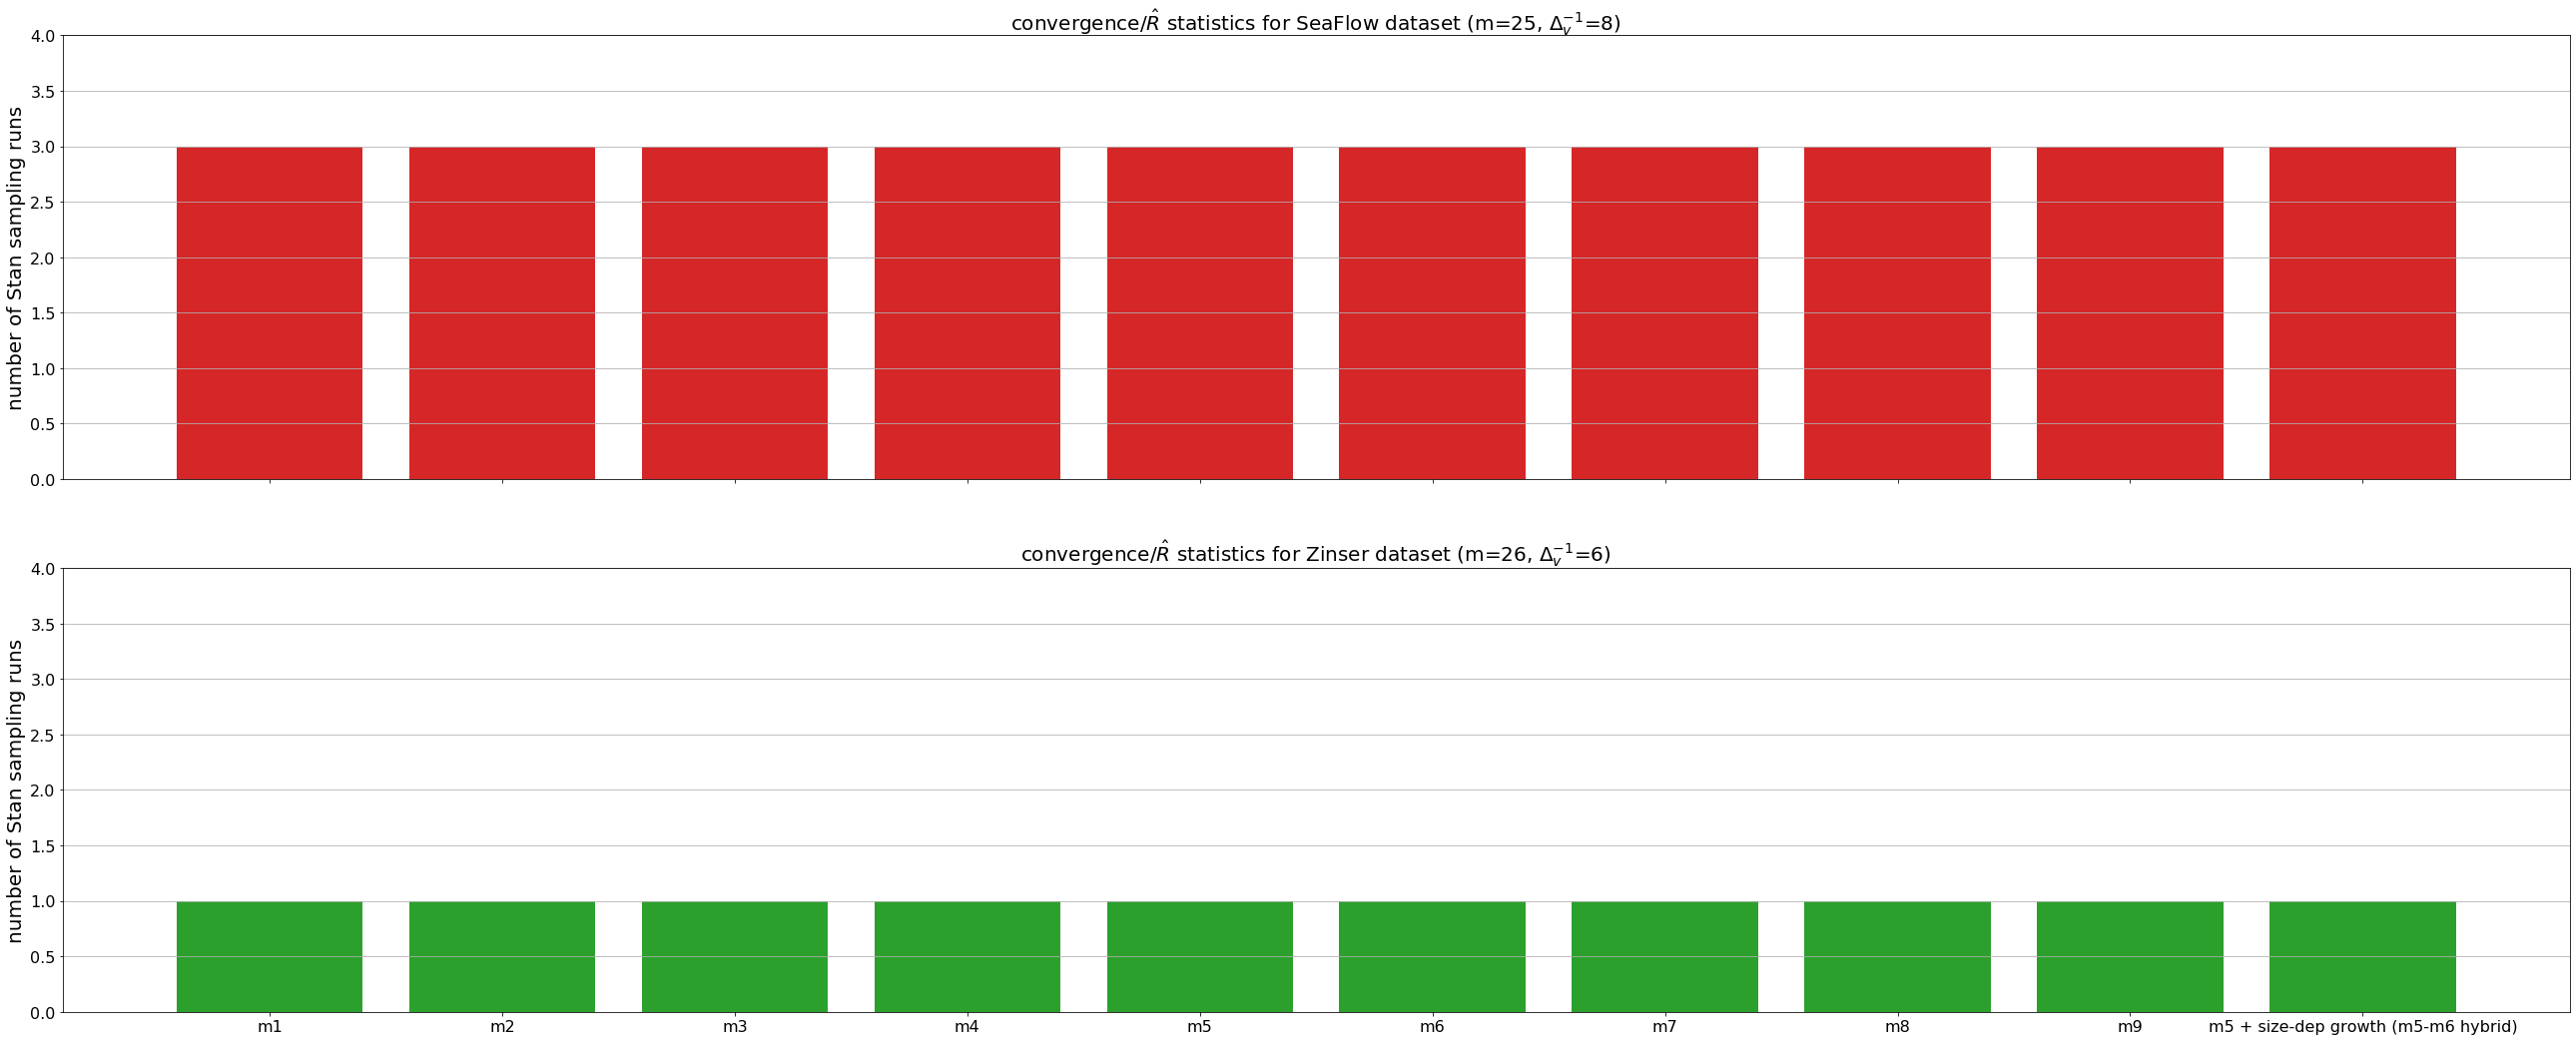

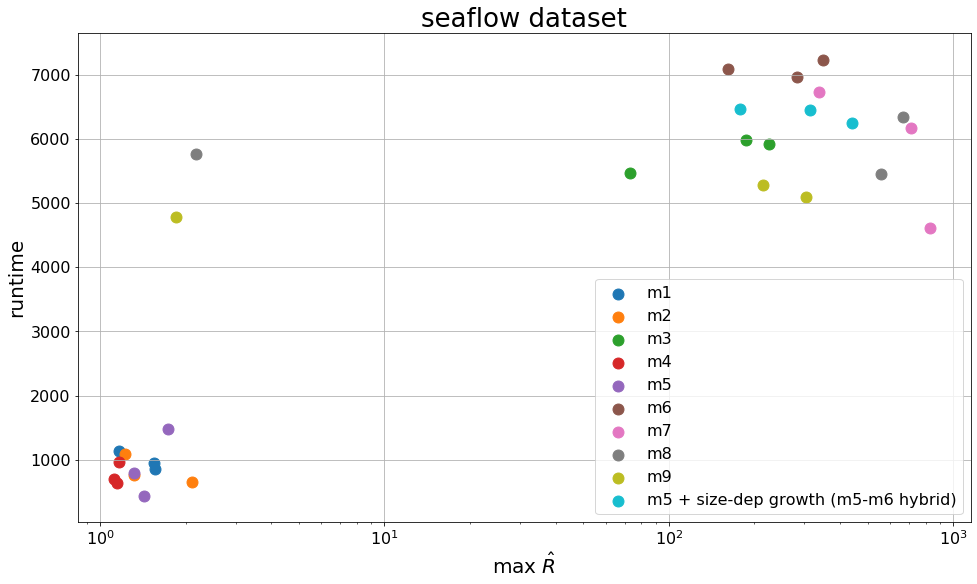

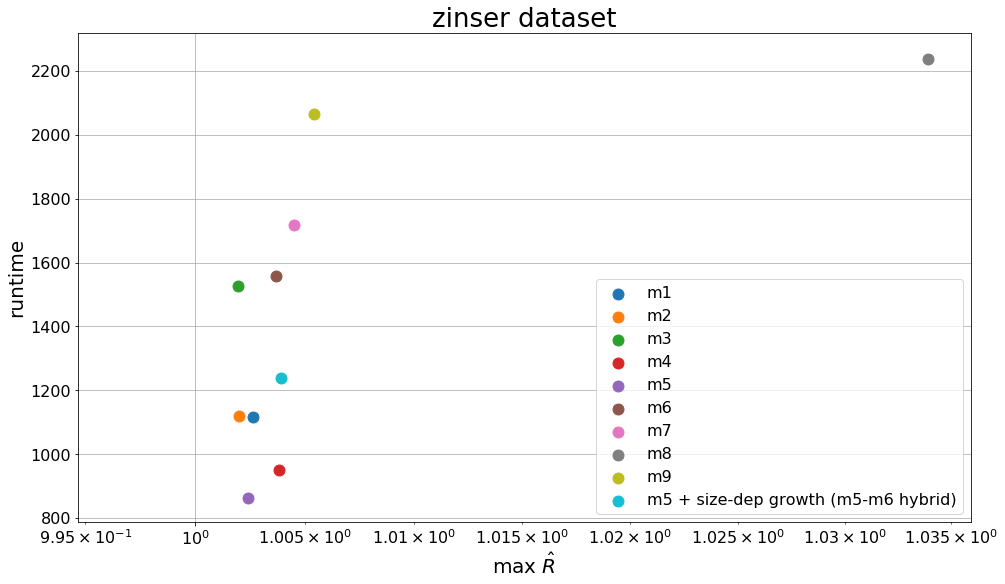

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

for dataname in data:
    fig, ax = plt.subplots(figsize=(16,9))
    ax.set_title('{} dataset'.format(dataname))
    for name in mcmcs:
        ax.scatter(maxrhats[name][dataname], sampling_time[name][dataname], label='{}'.format(desc_model[name]), s=120)

    ax.set(xlabel='max $\\hat{R}$', ylabel='runtime')
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()

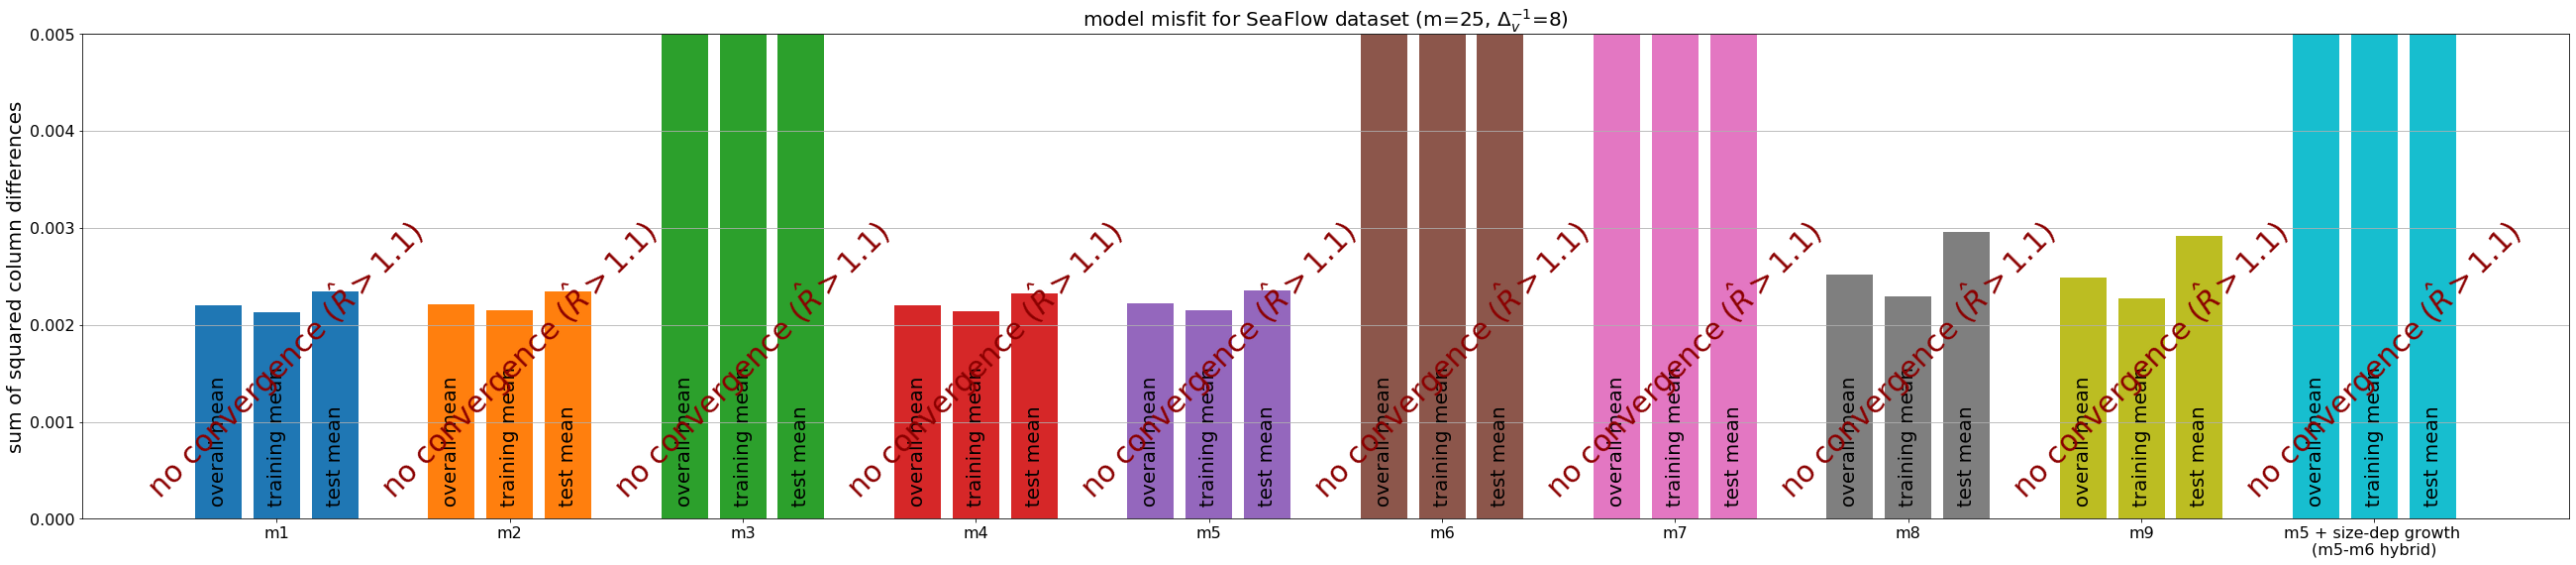

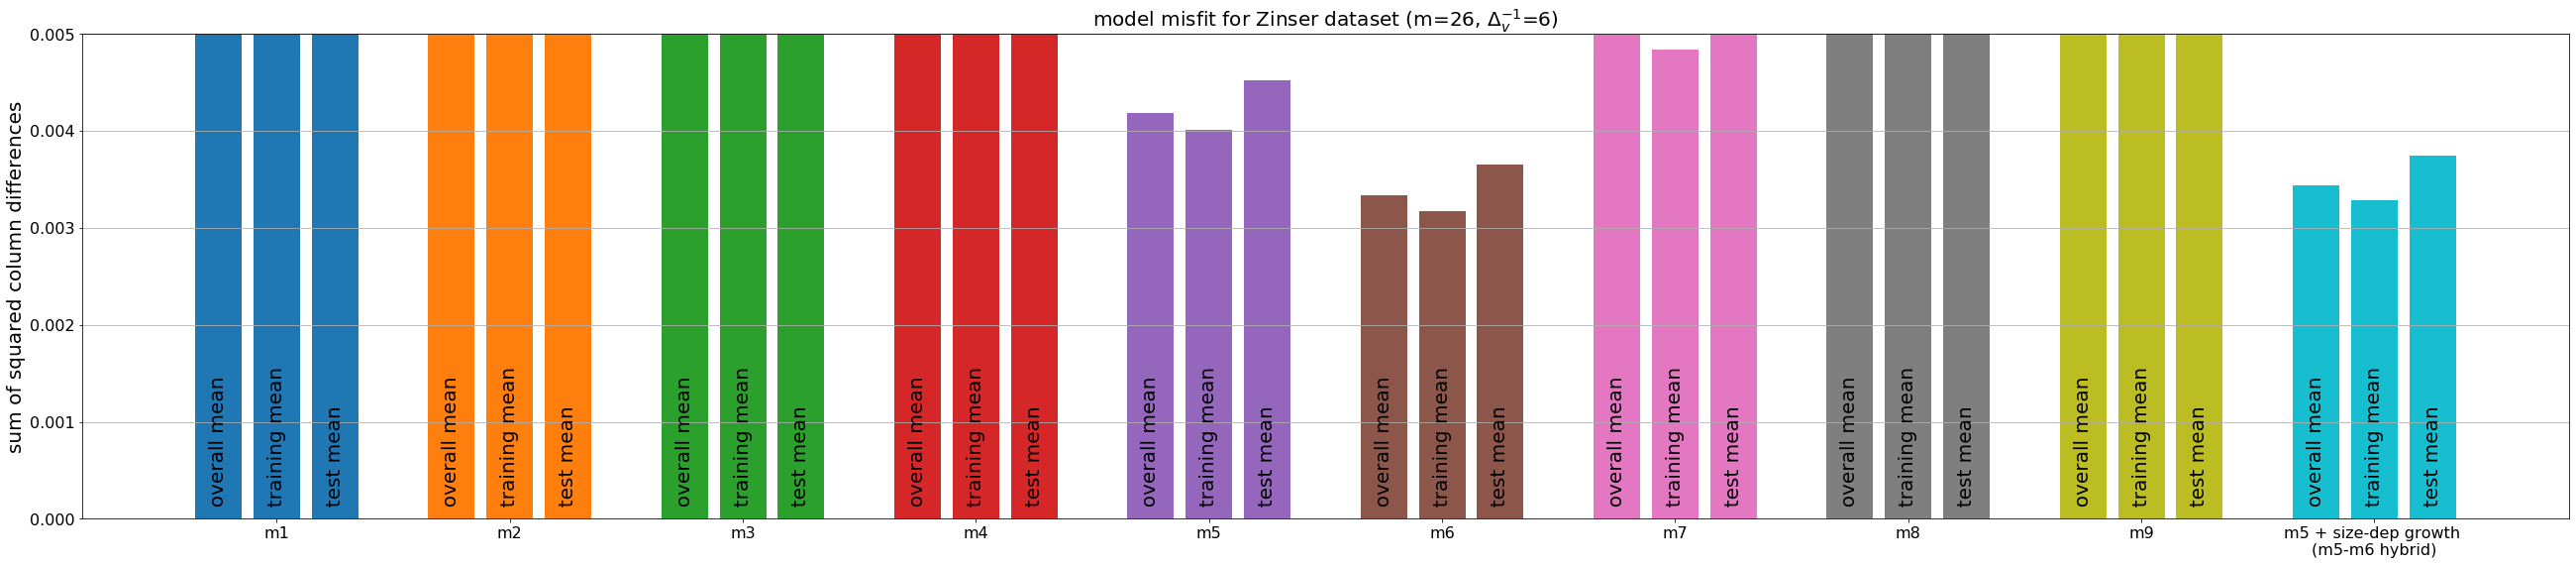

In [9]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

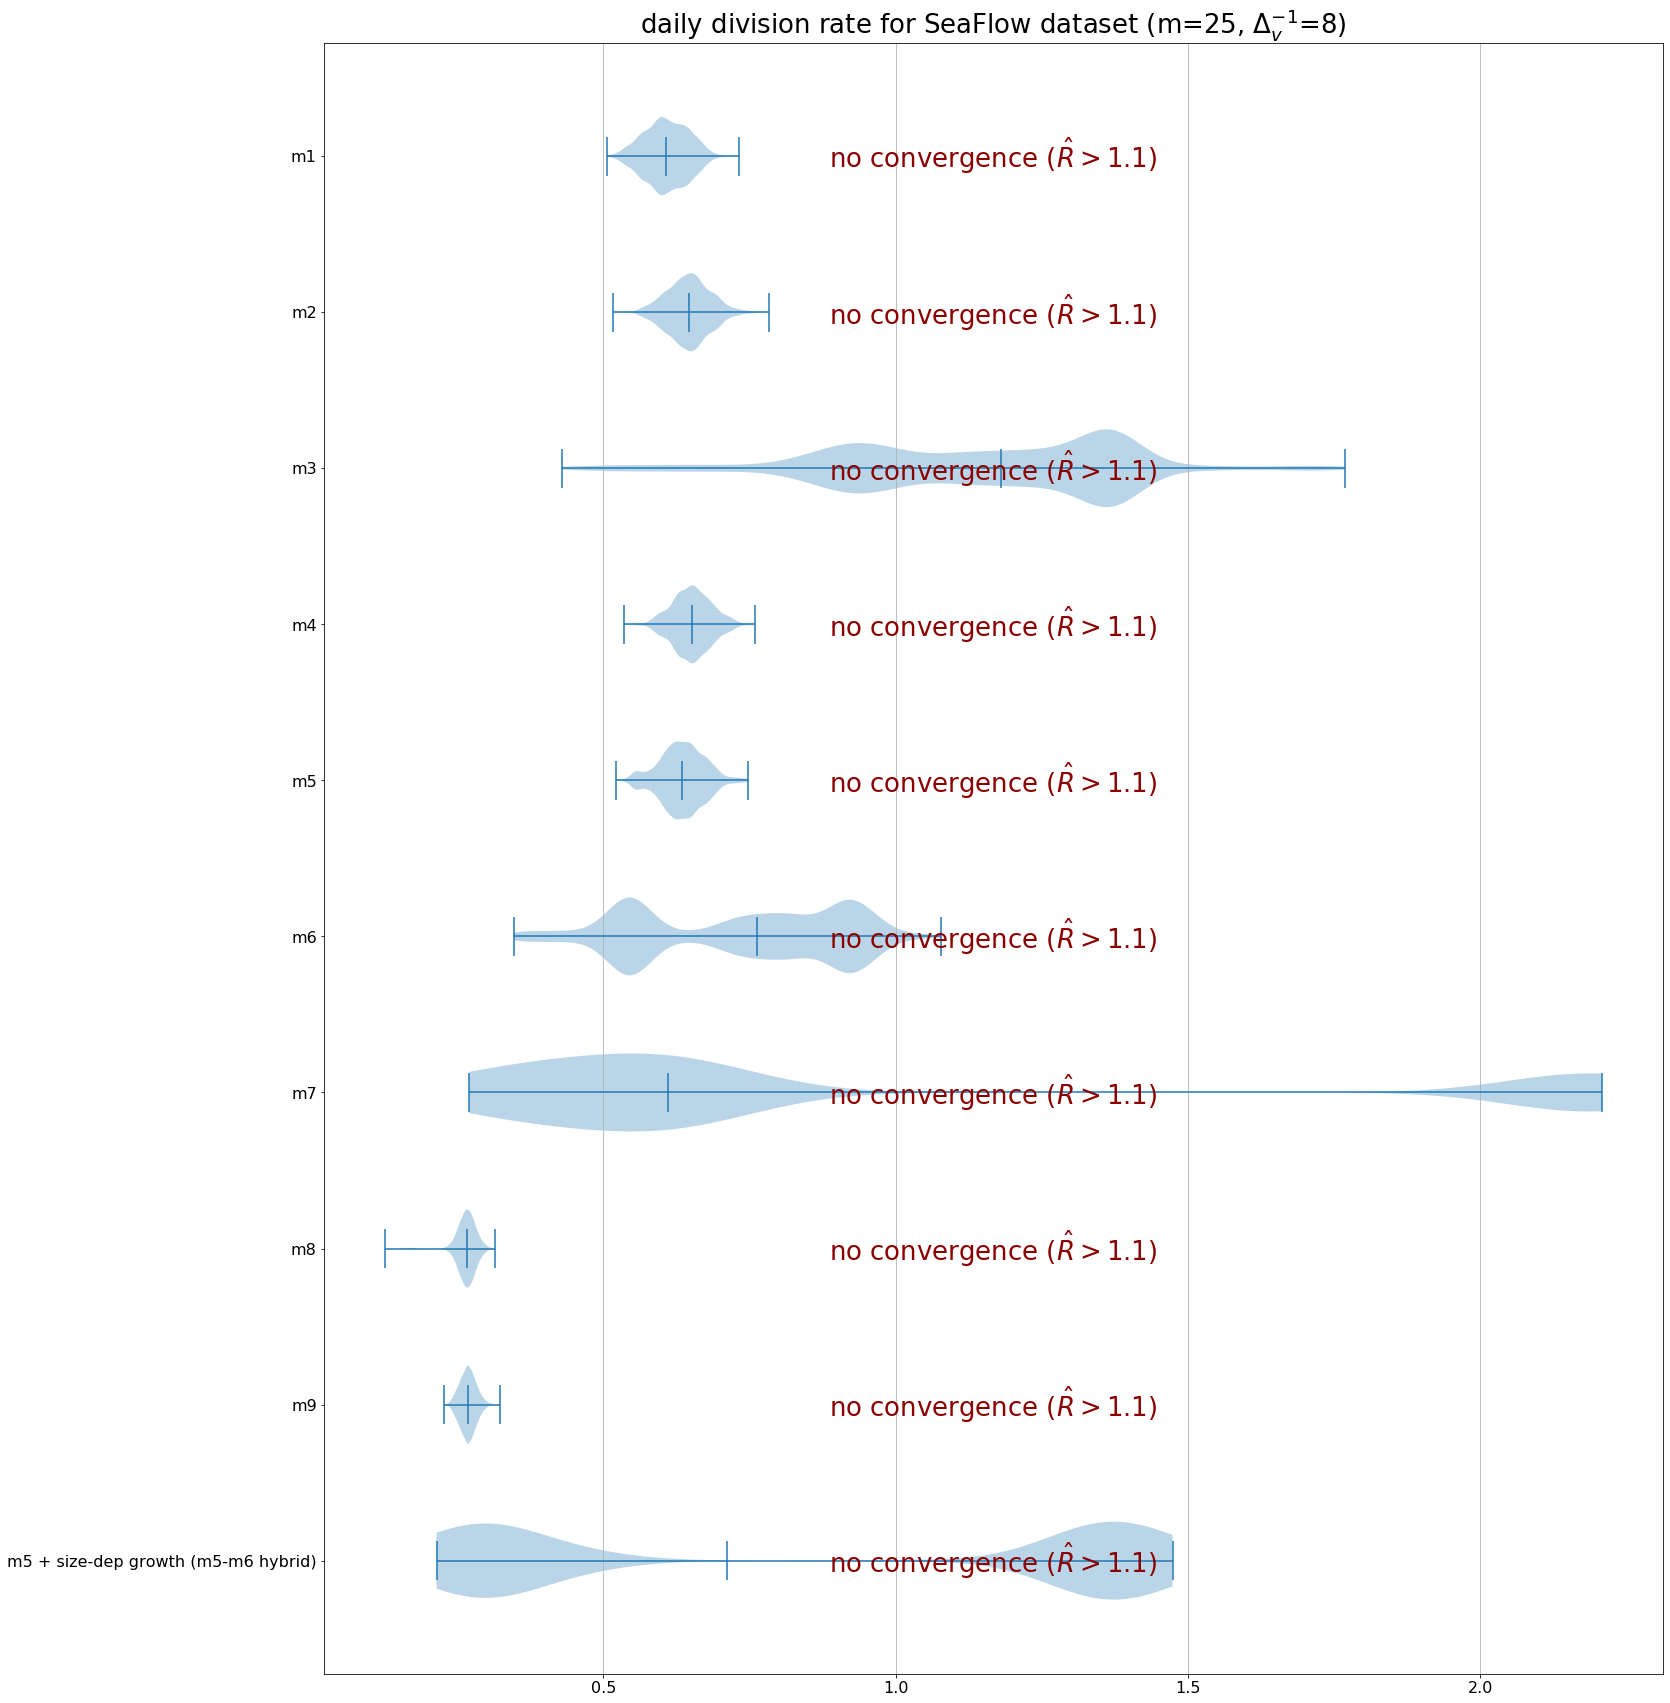

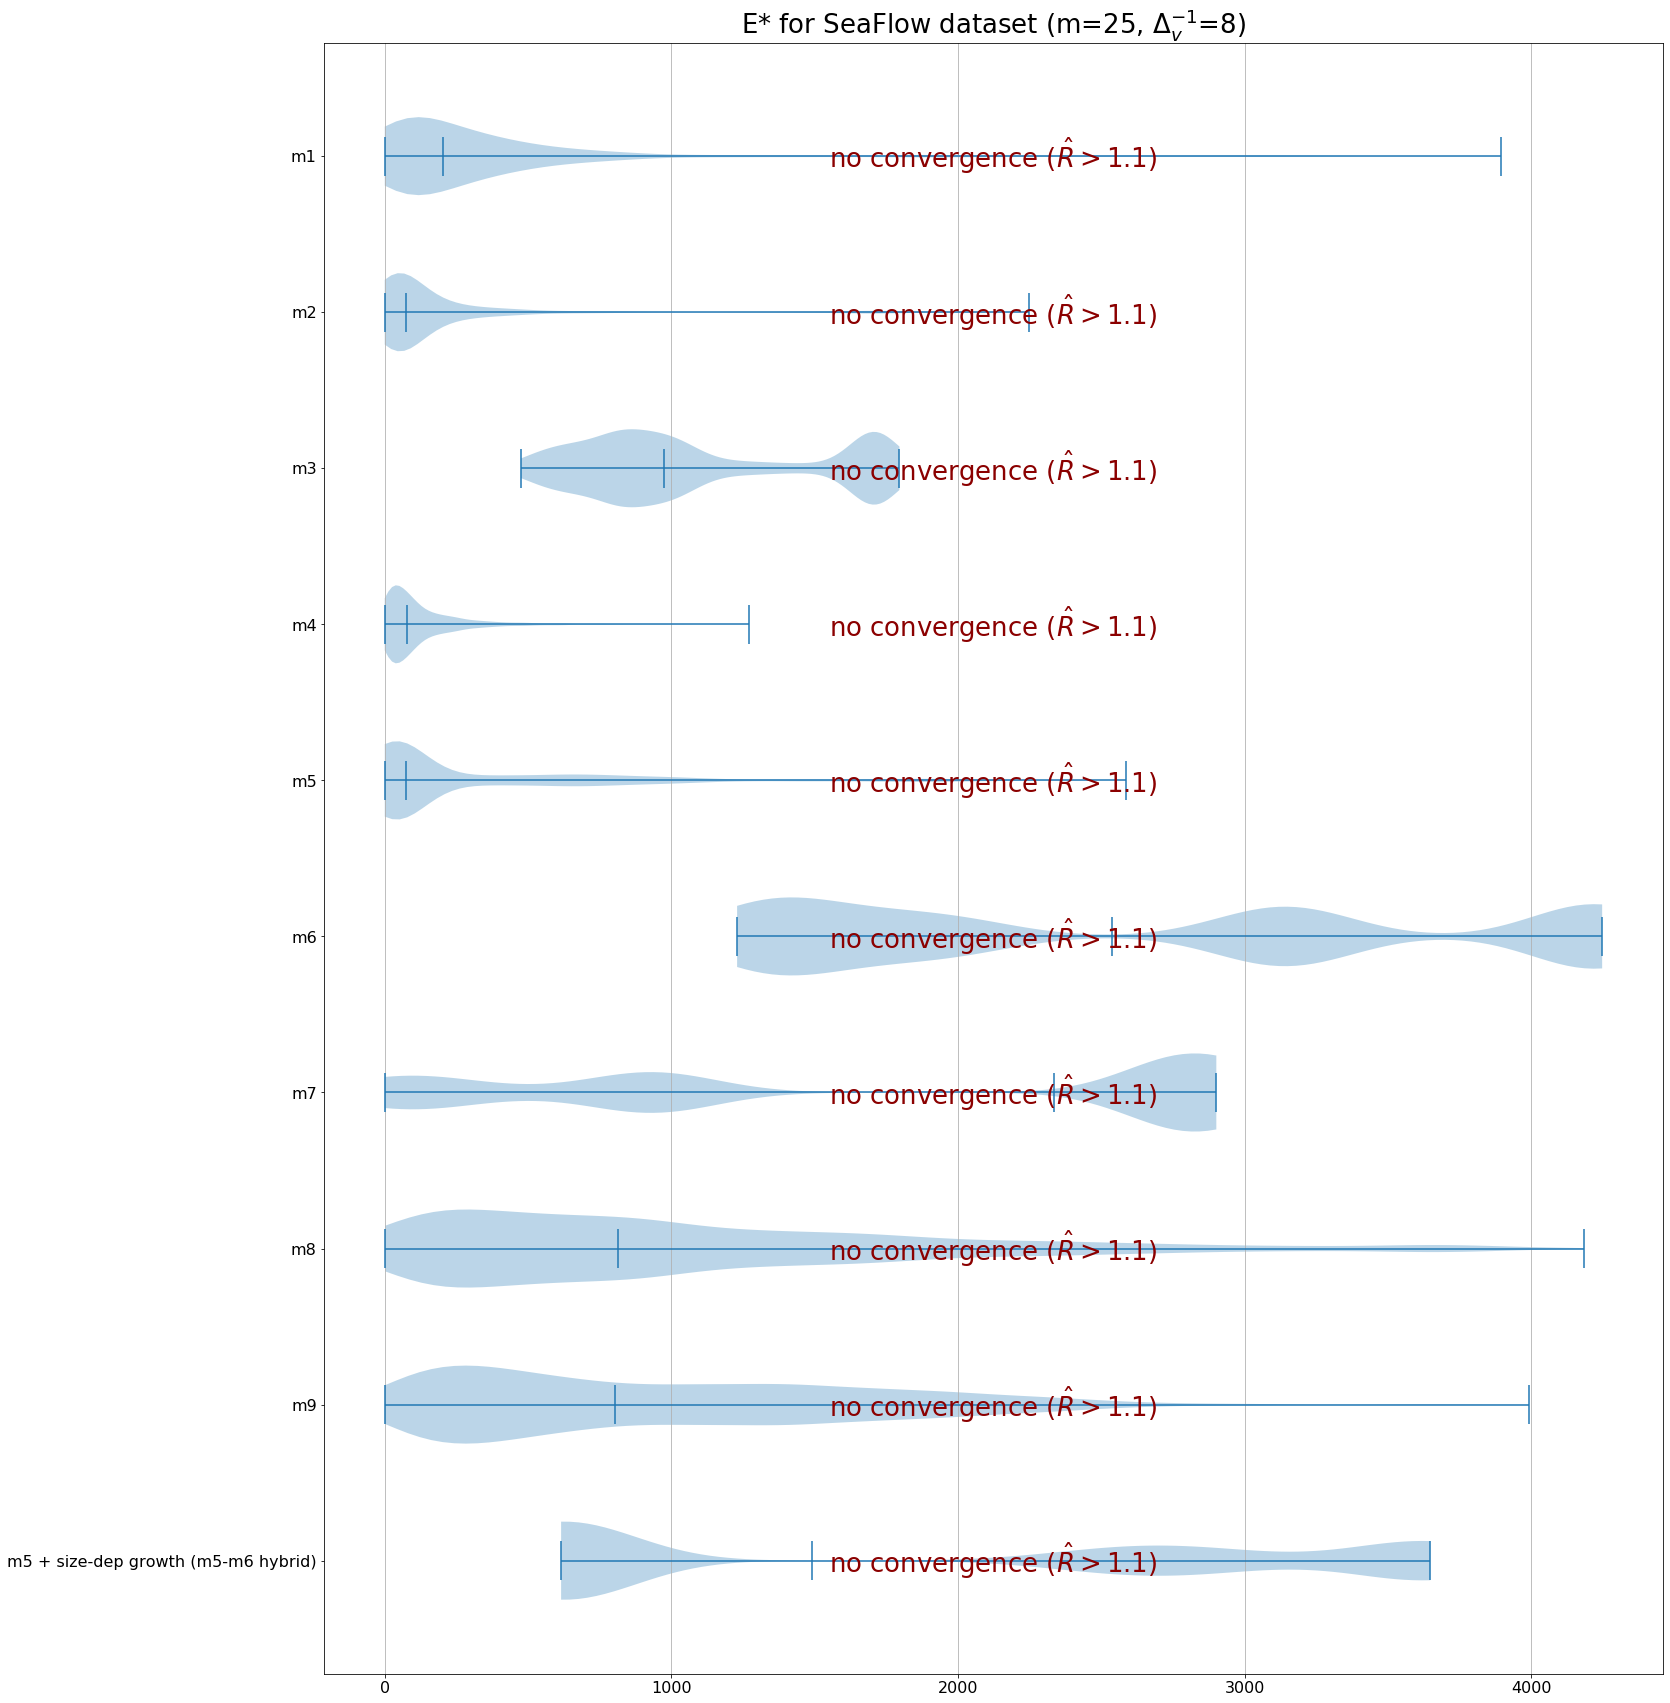

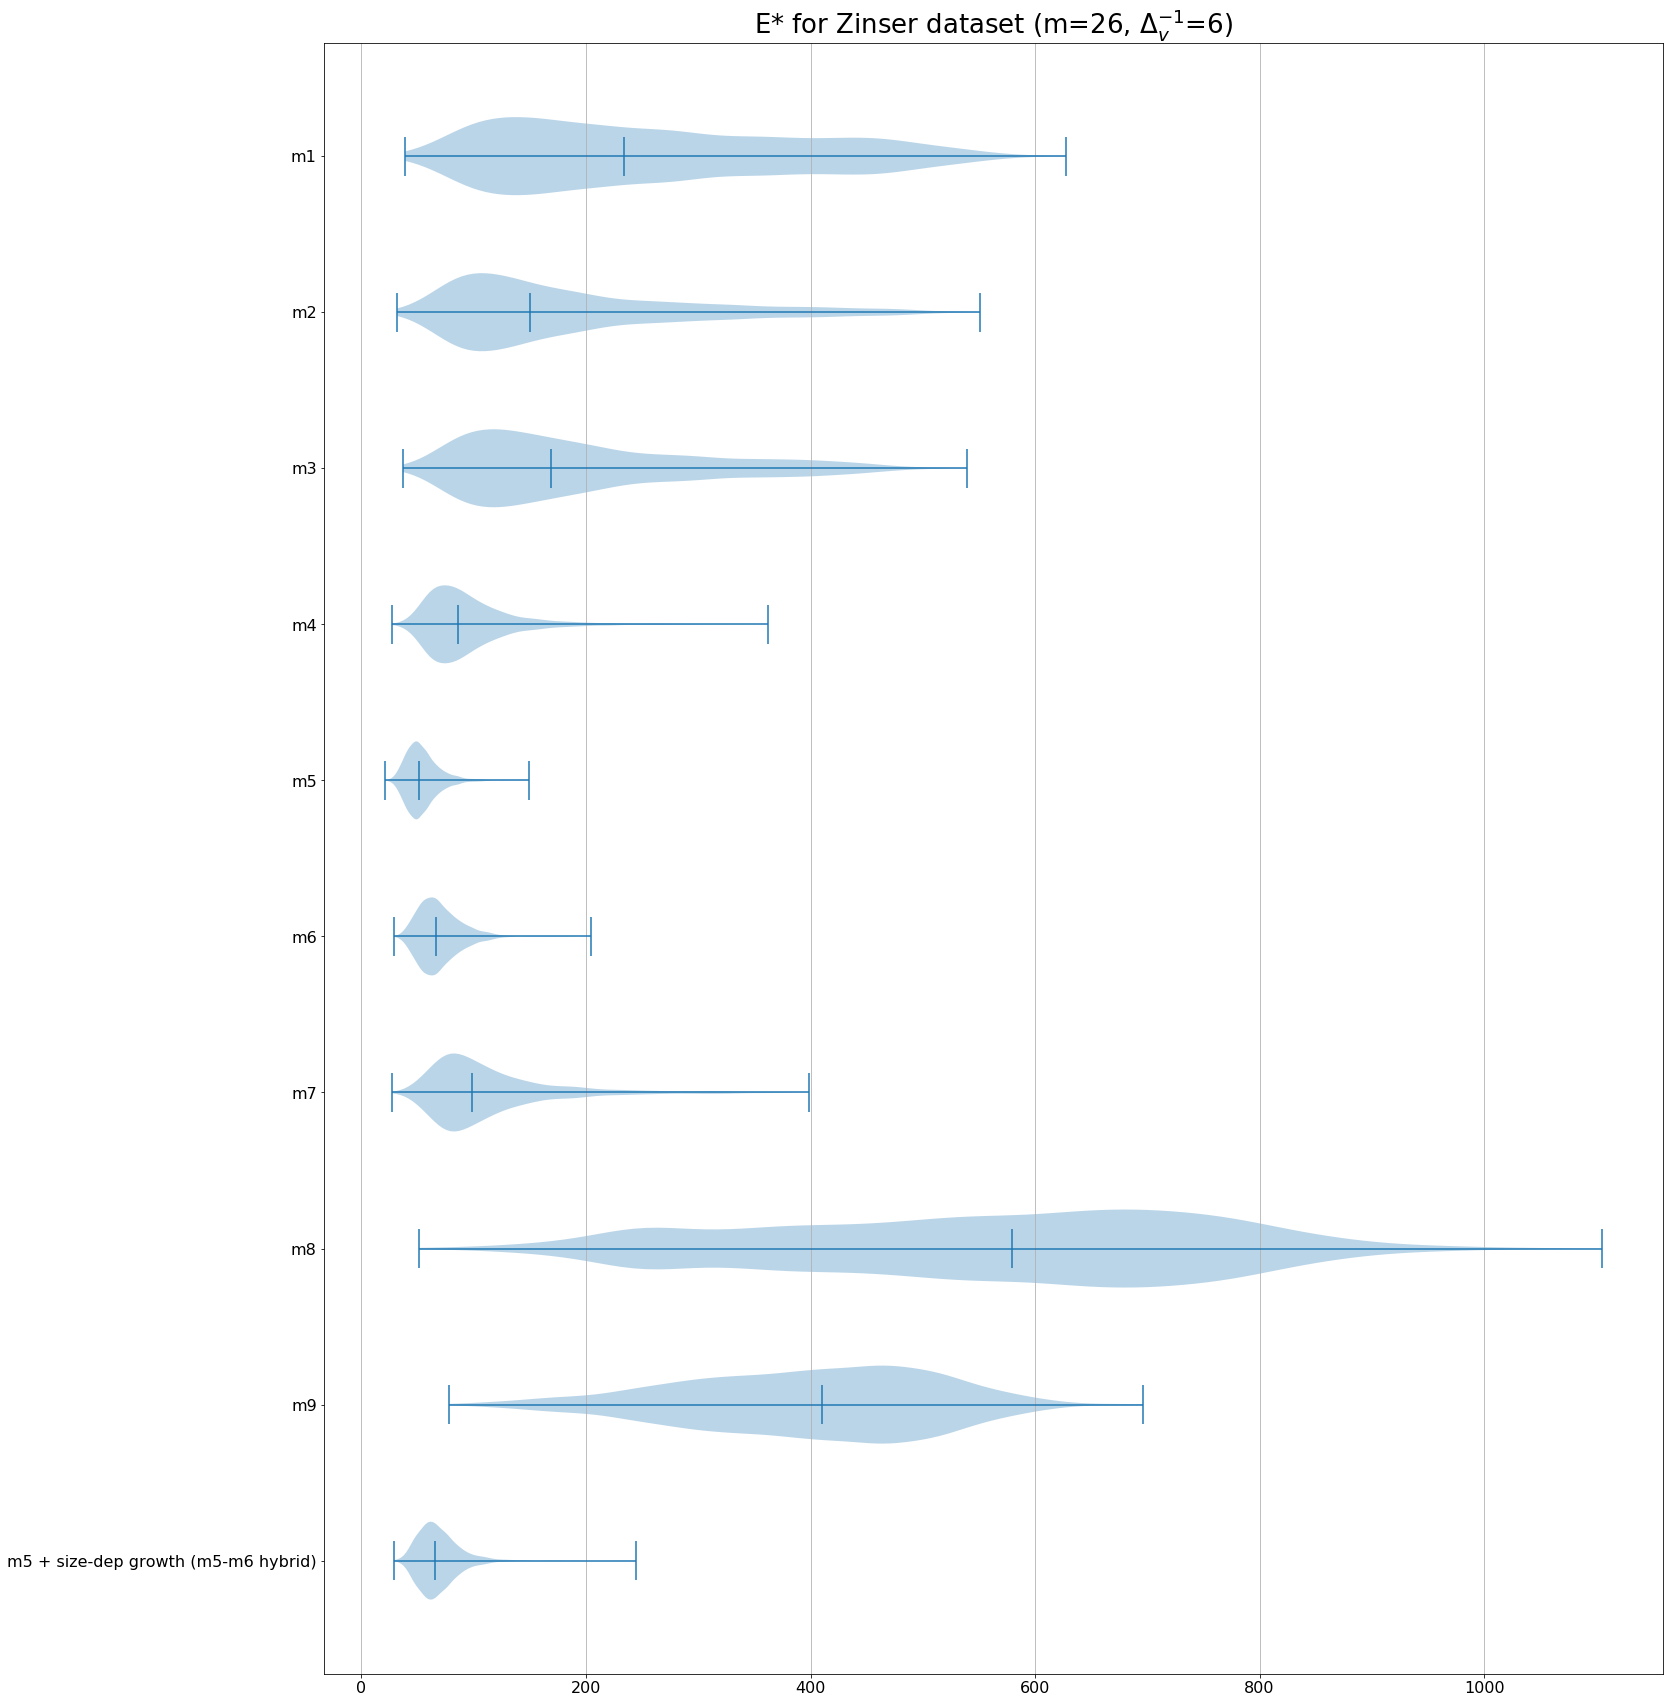

In [10]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.63}}

for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[name][dataname][param] for name in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,name in enumerate(mcmcs):
            if maxrhats_final[name][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

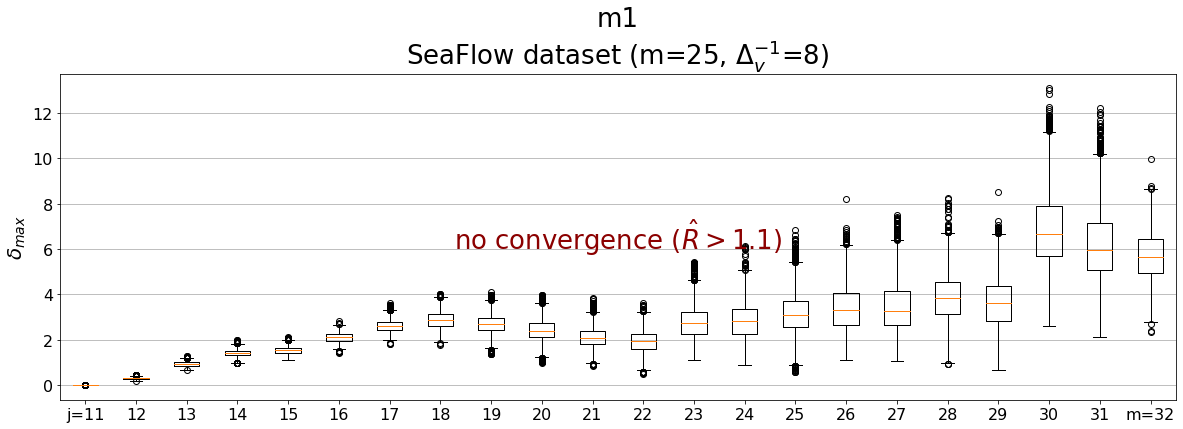

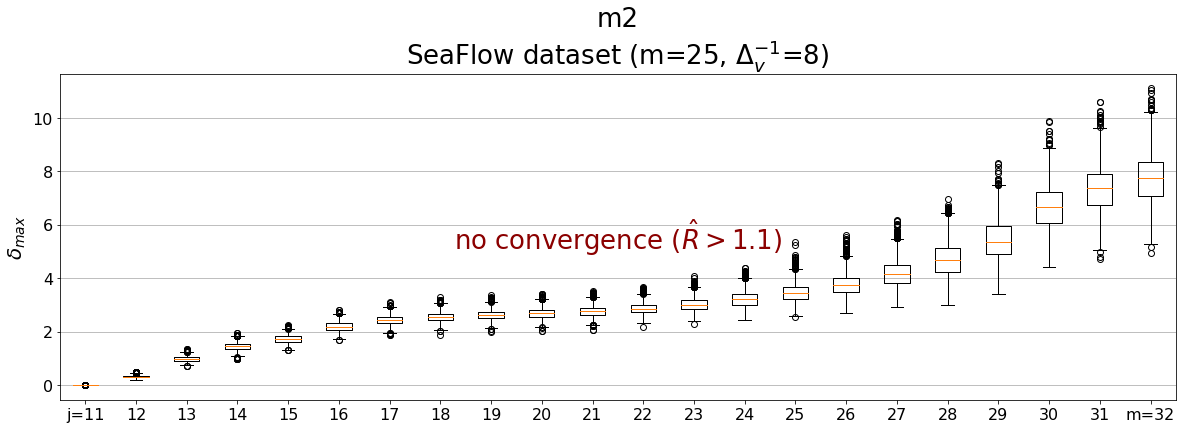

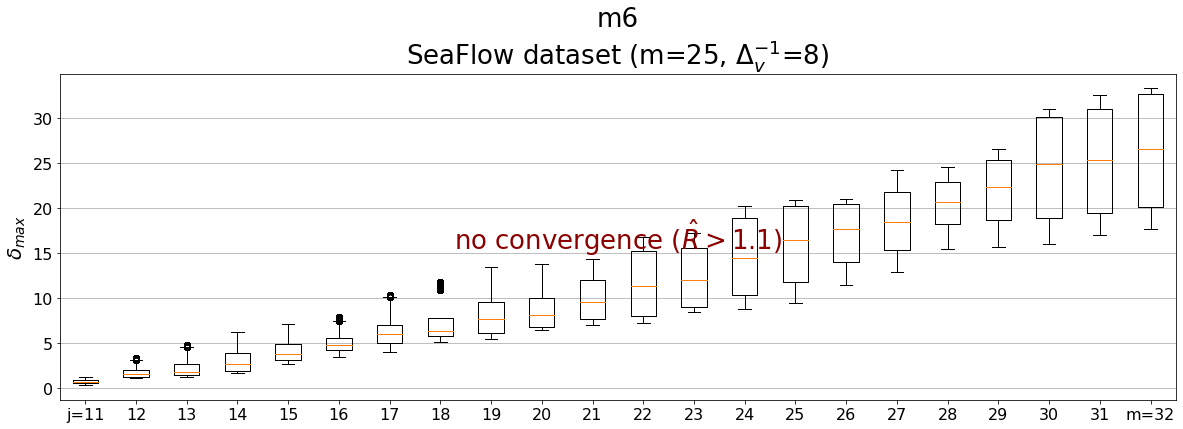

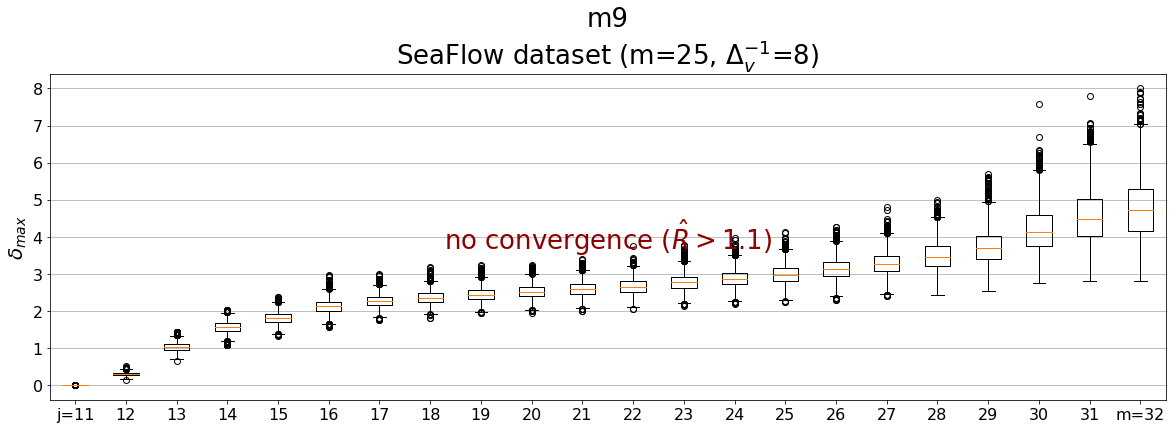

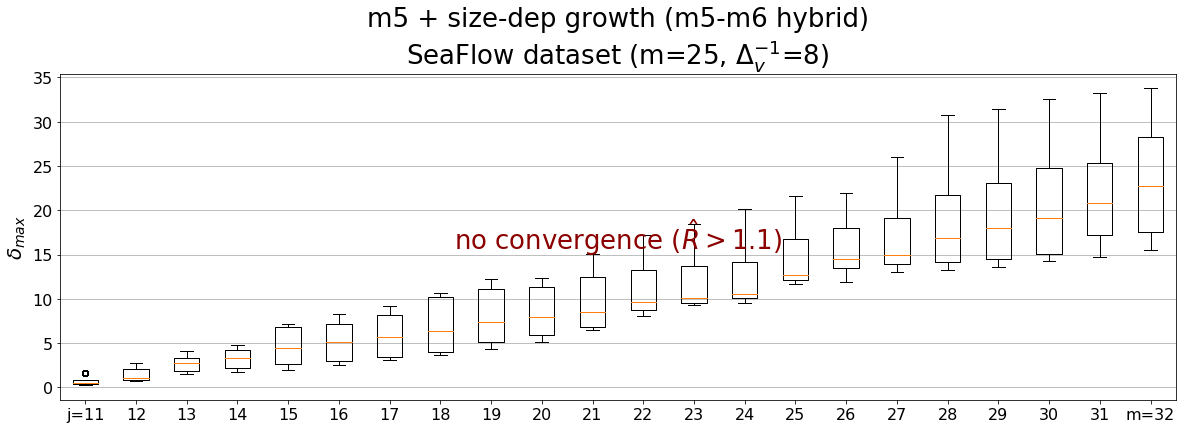

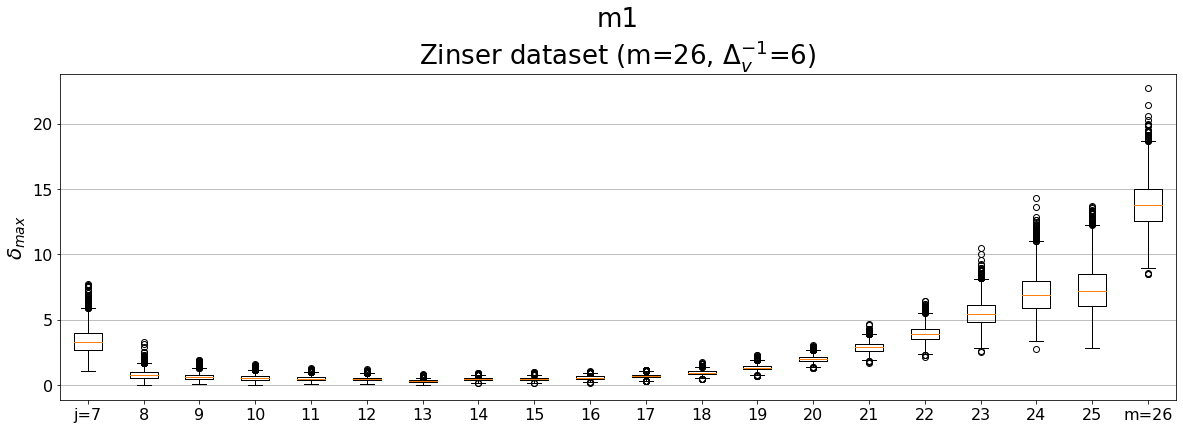

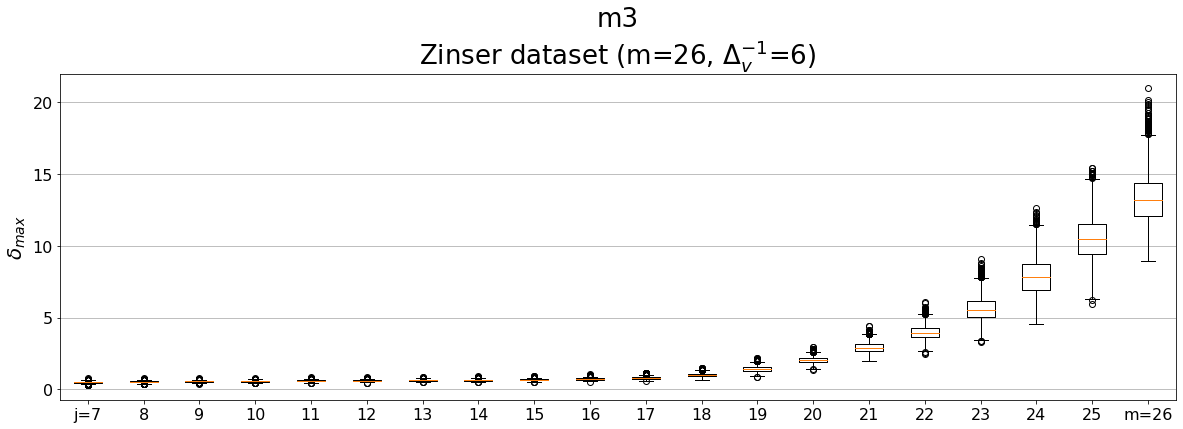

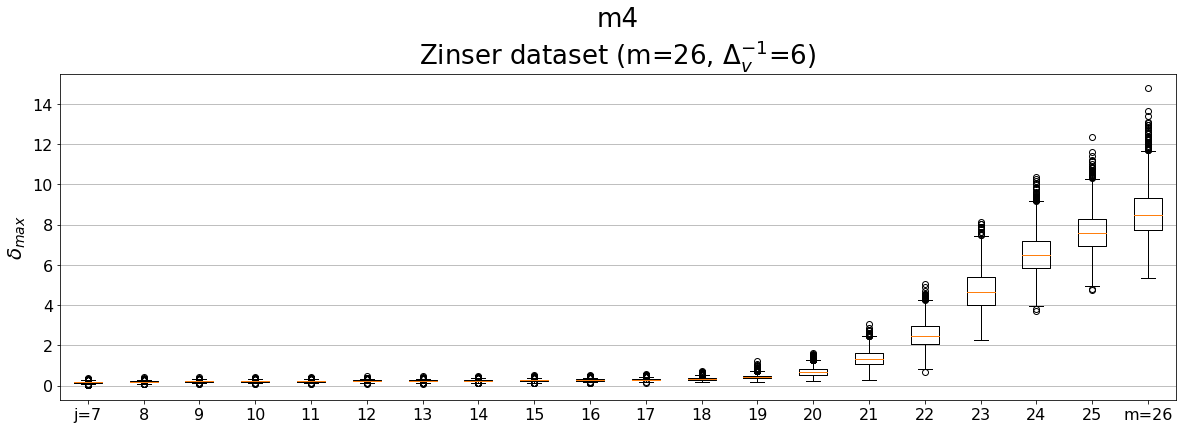

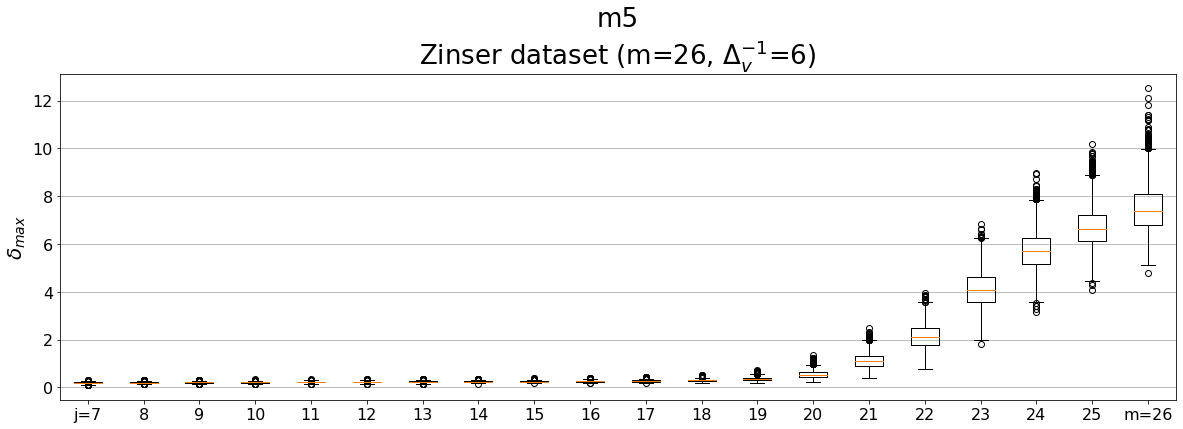

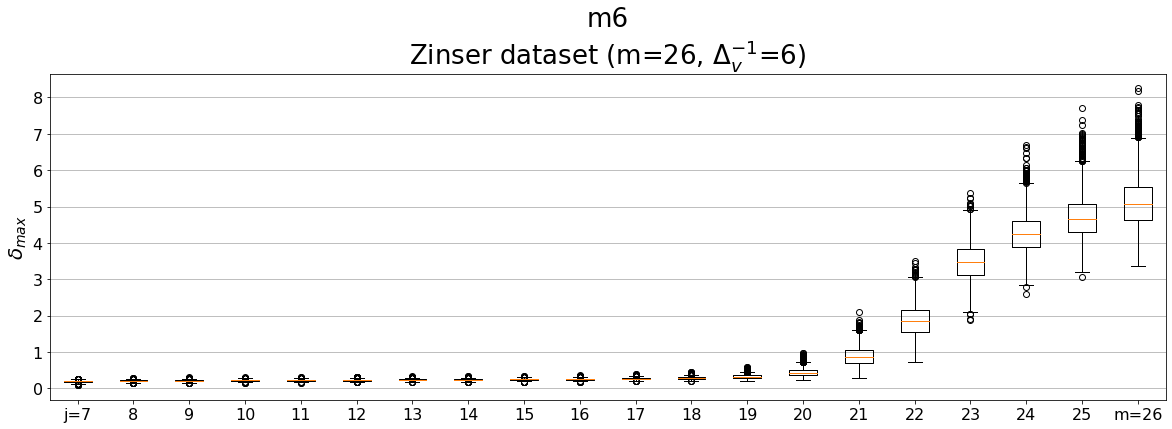

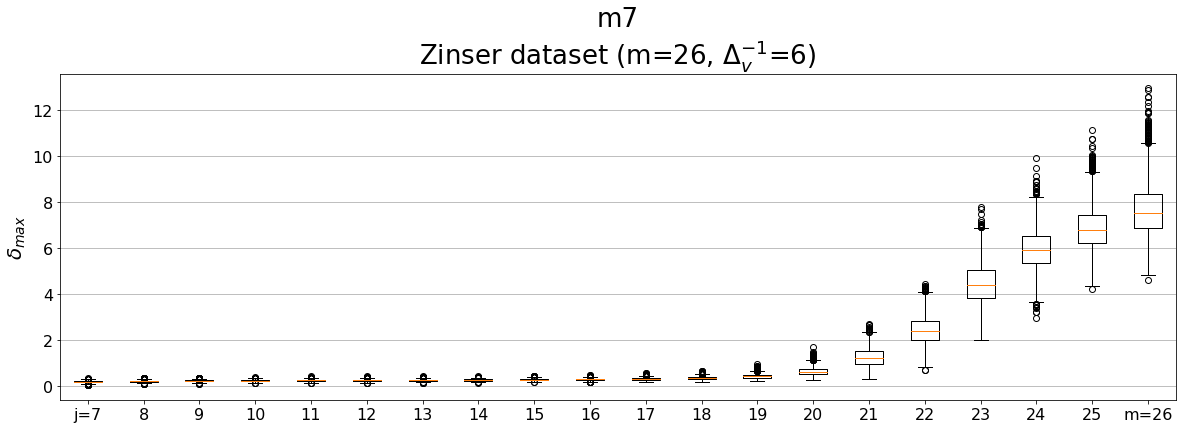

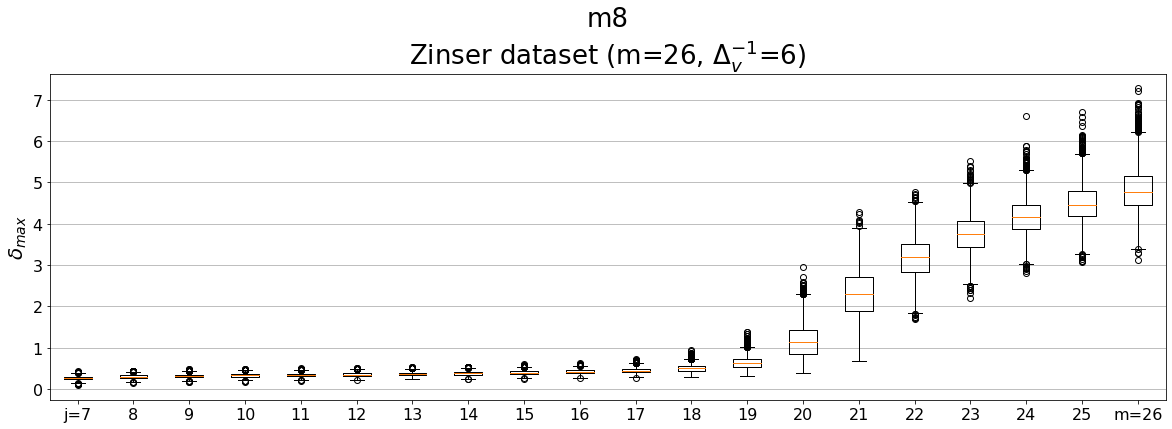

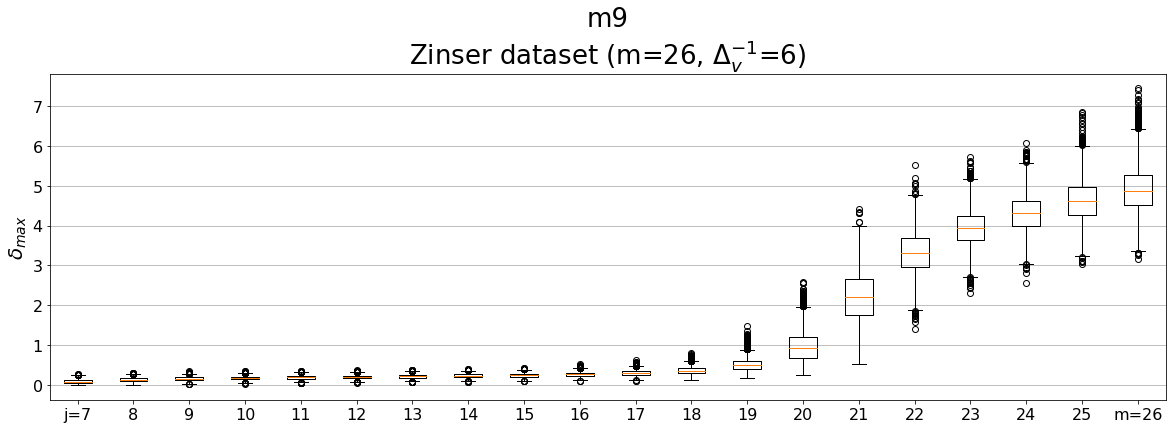

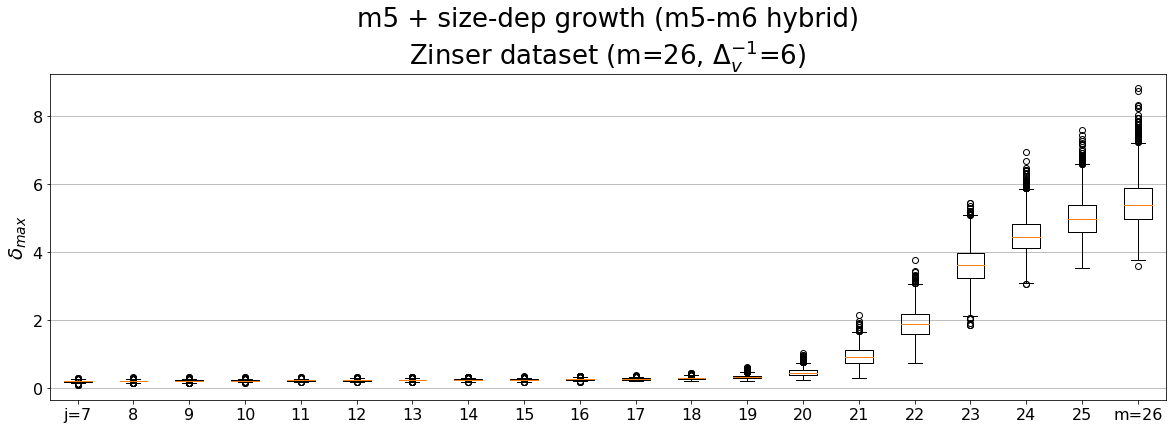

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

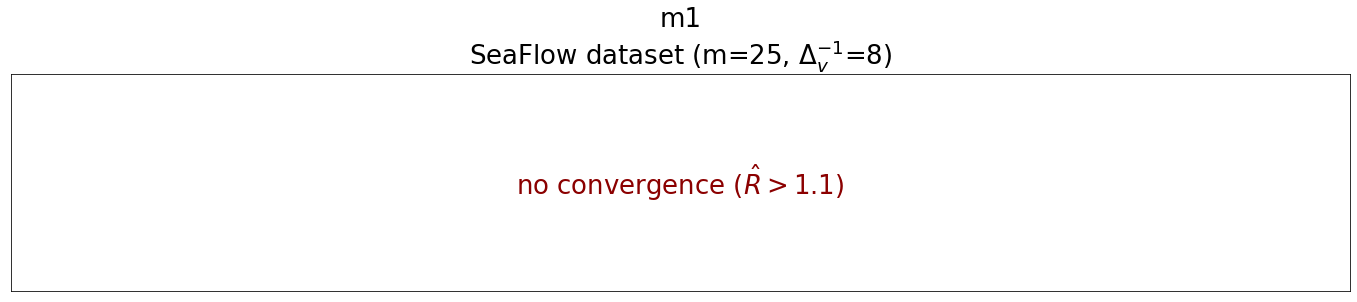

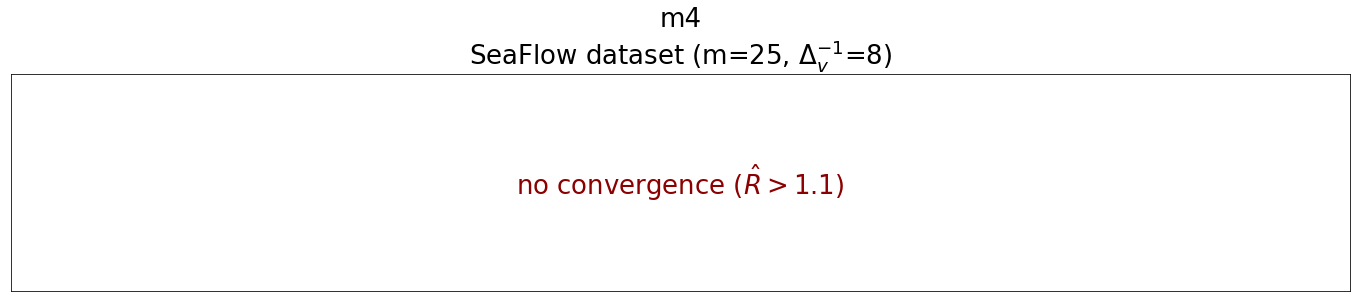

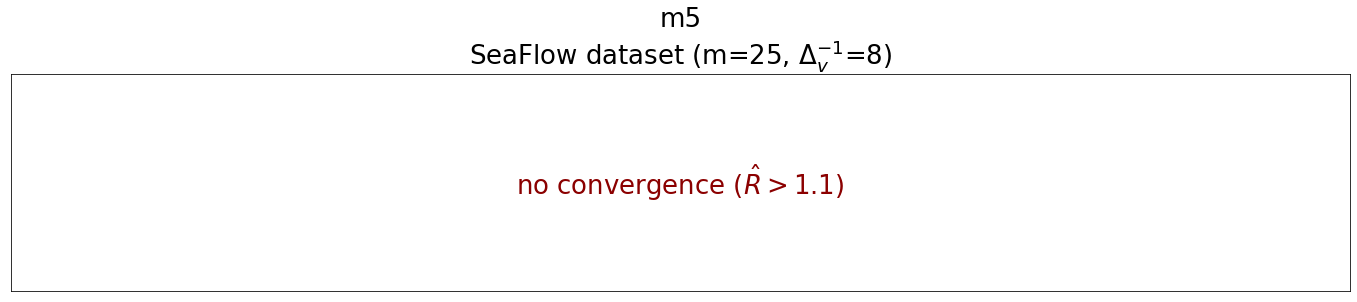

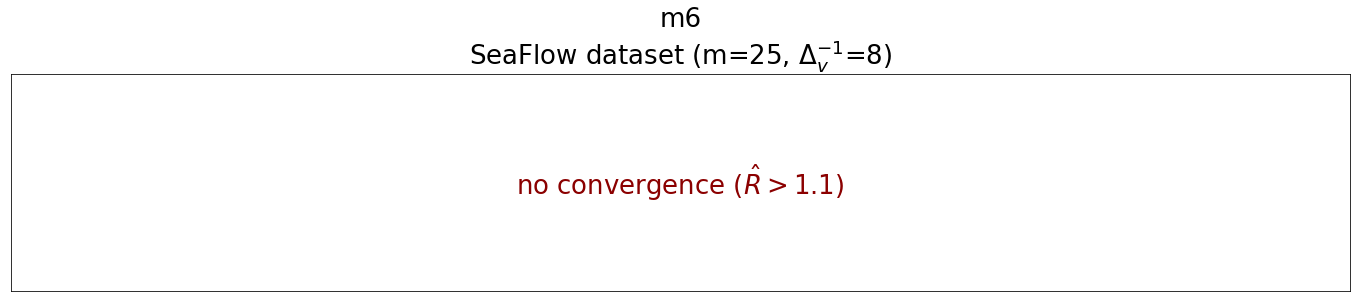

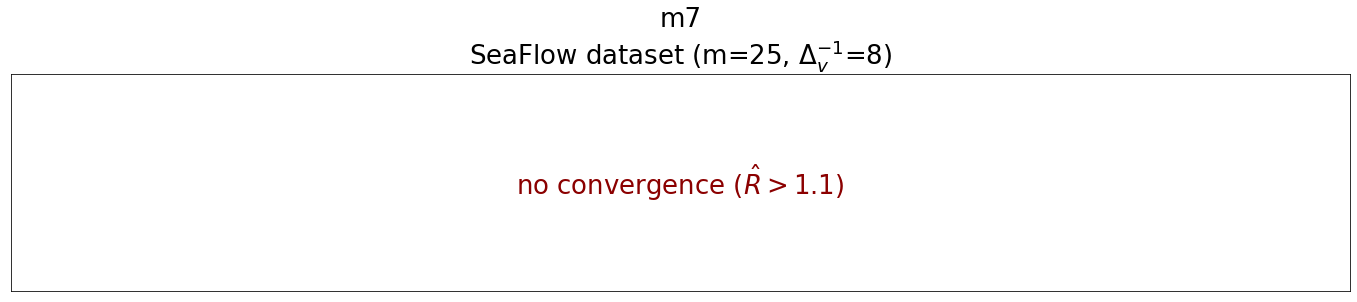

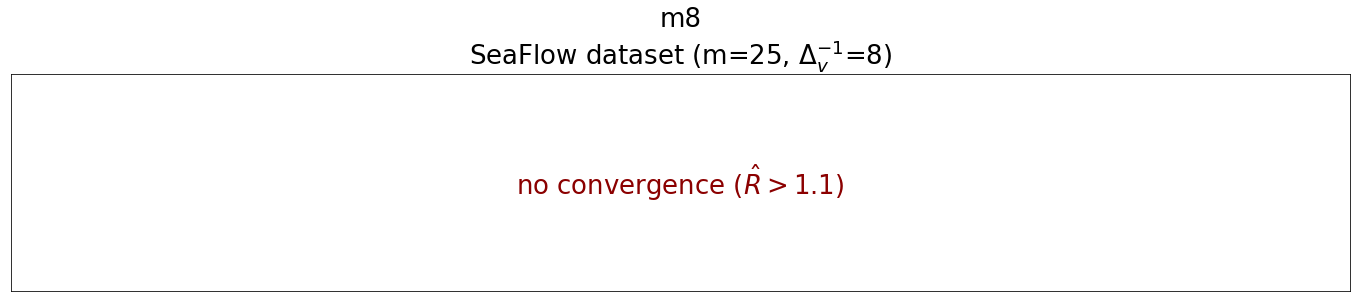

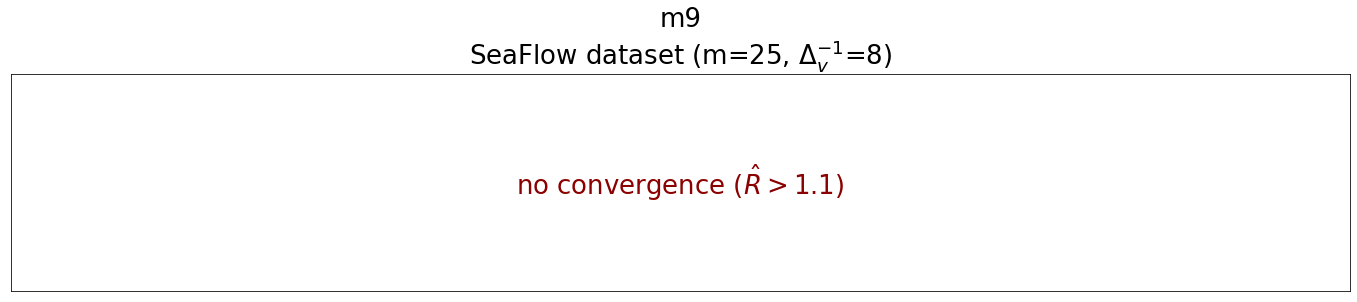

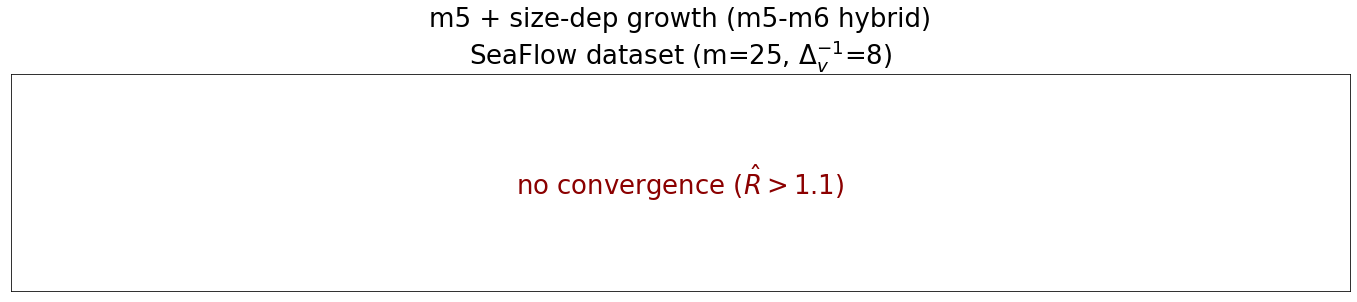

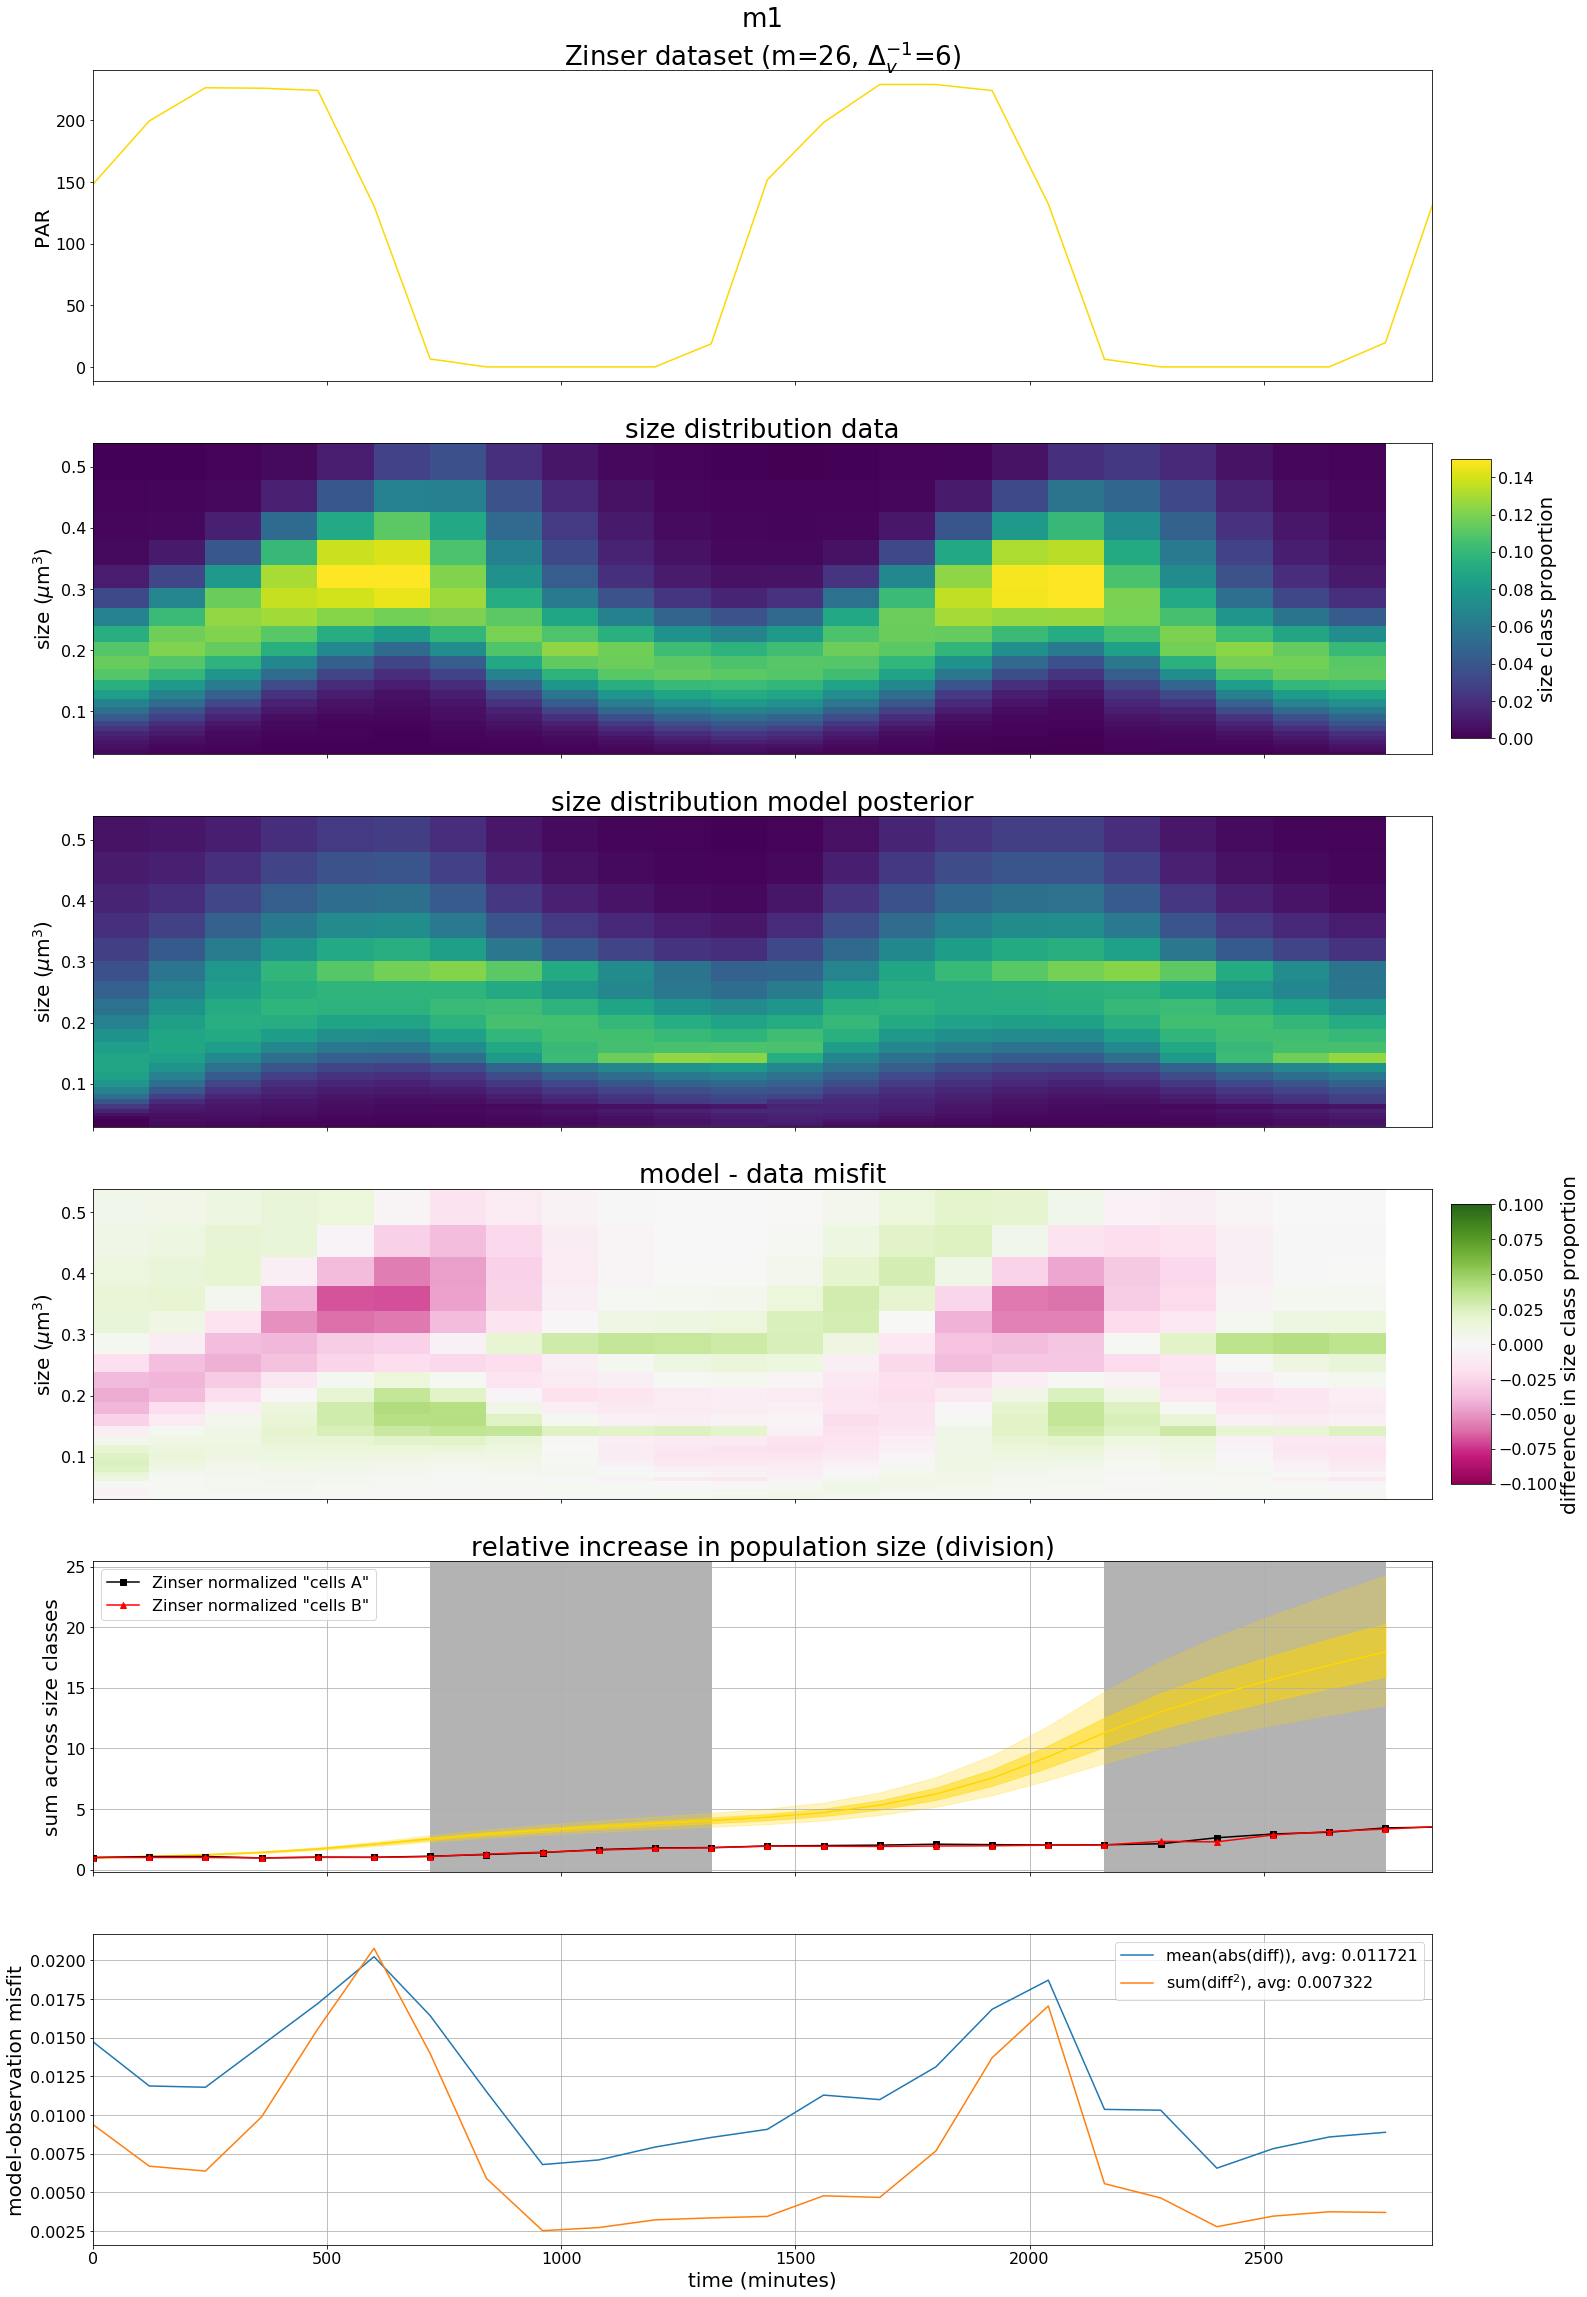

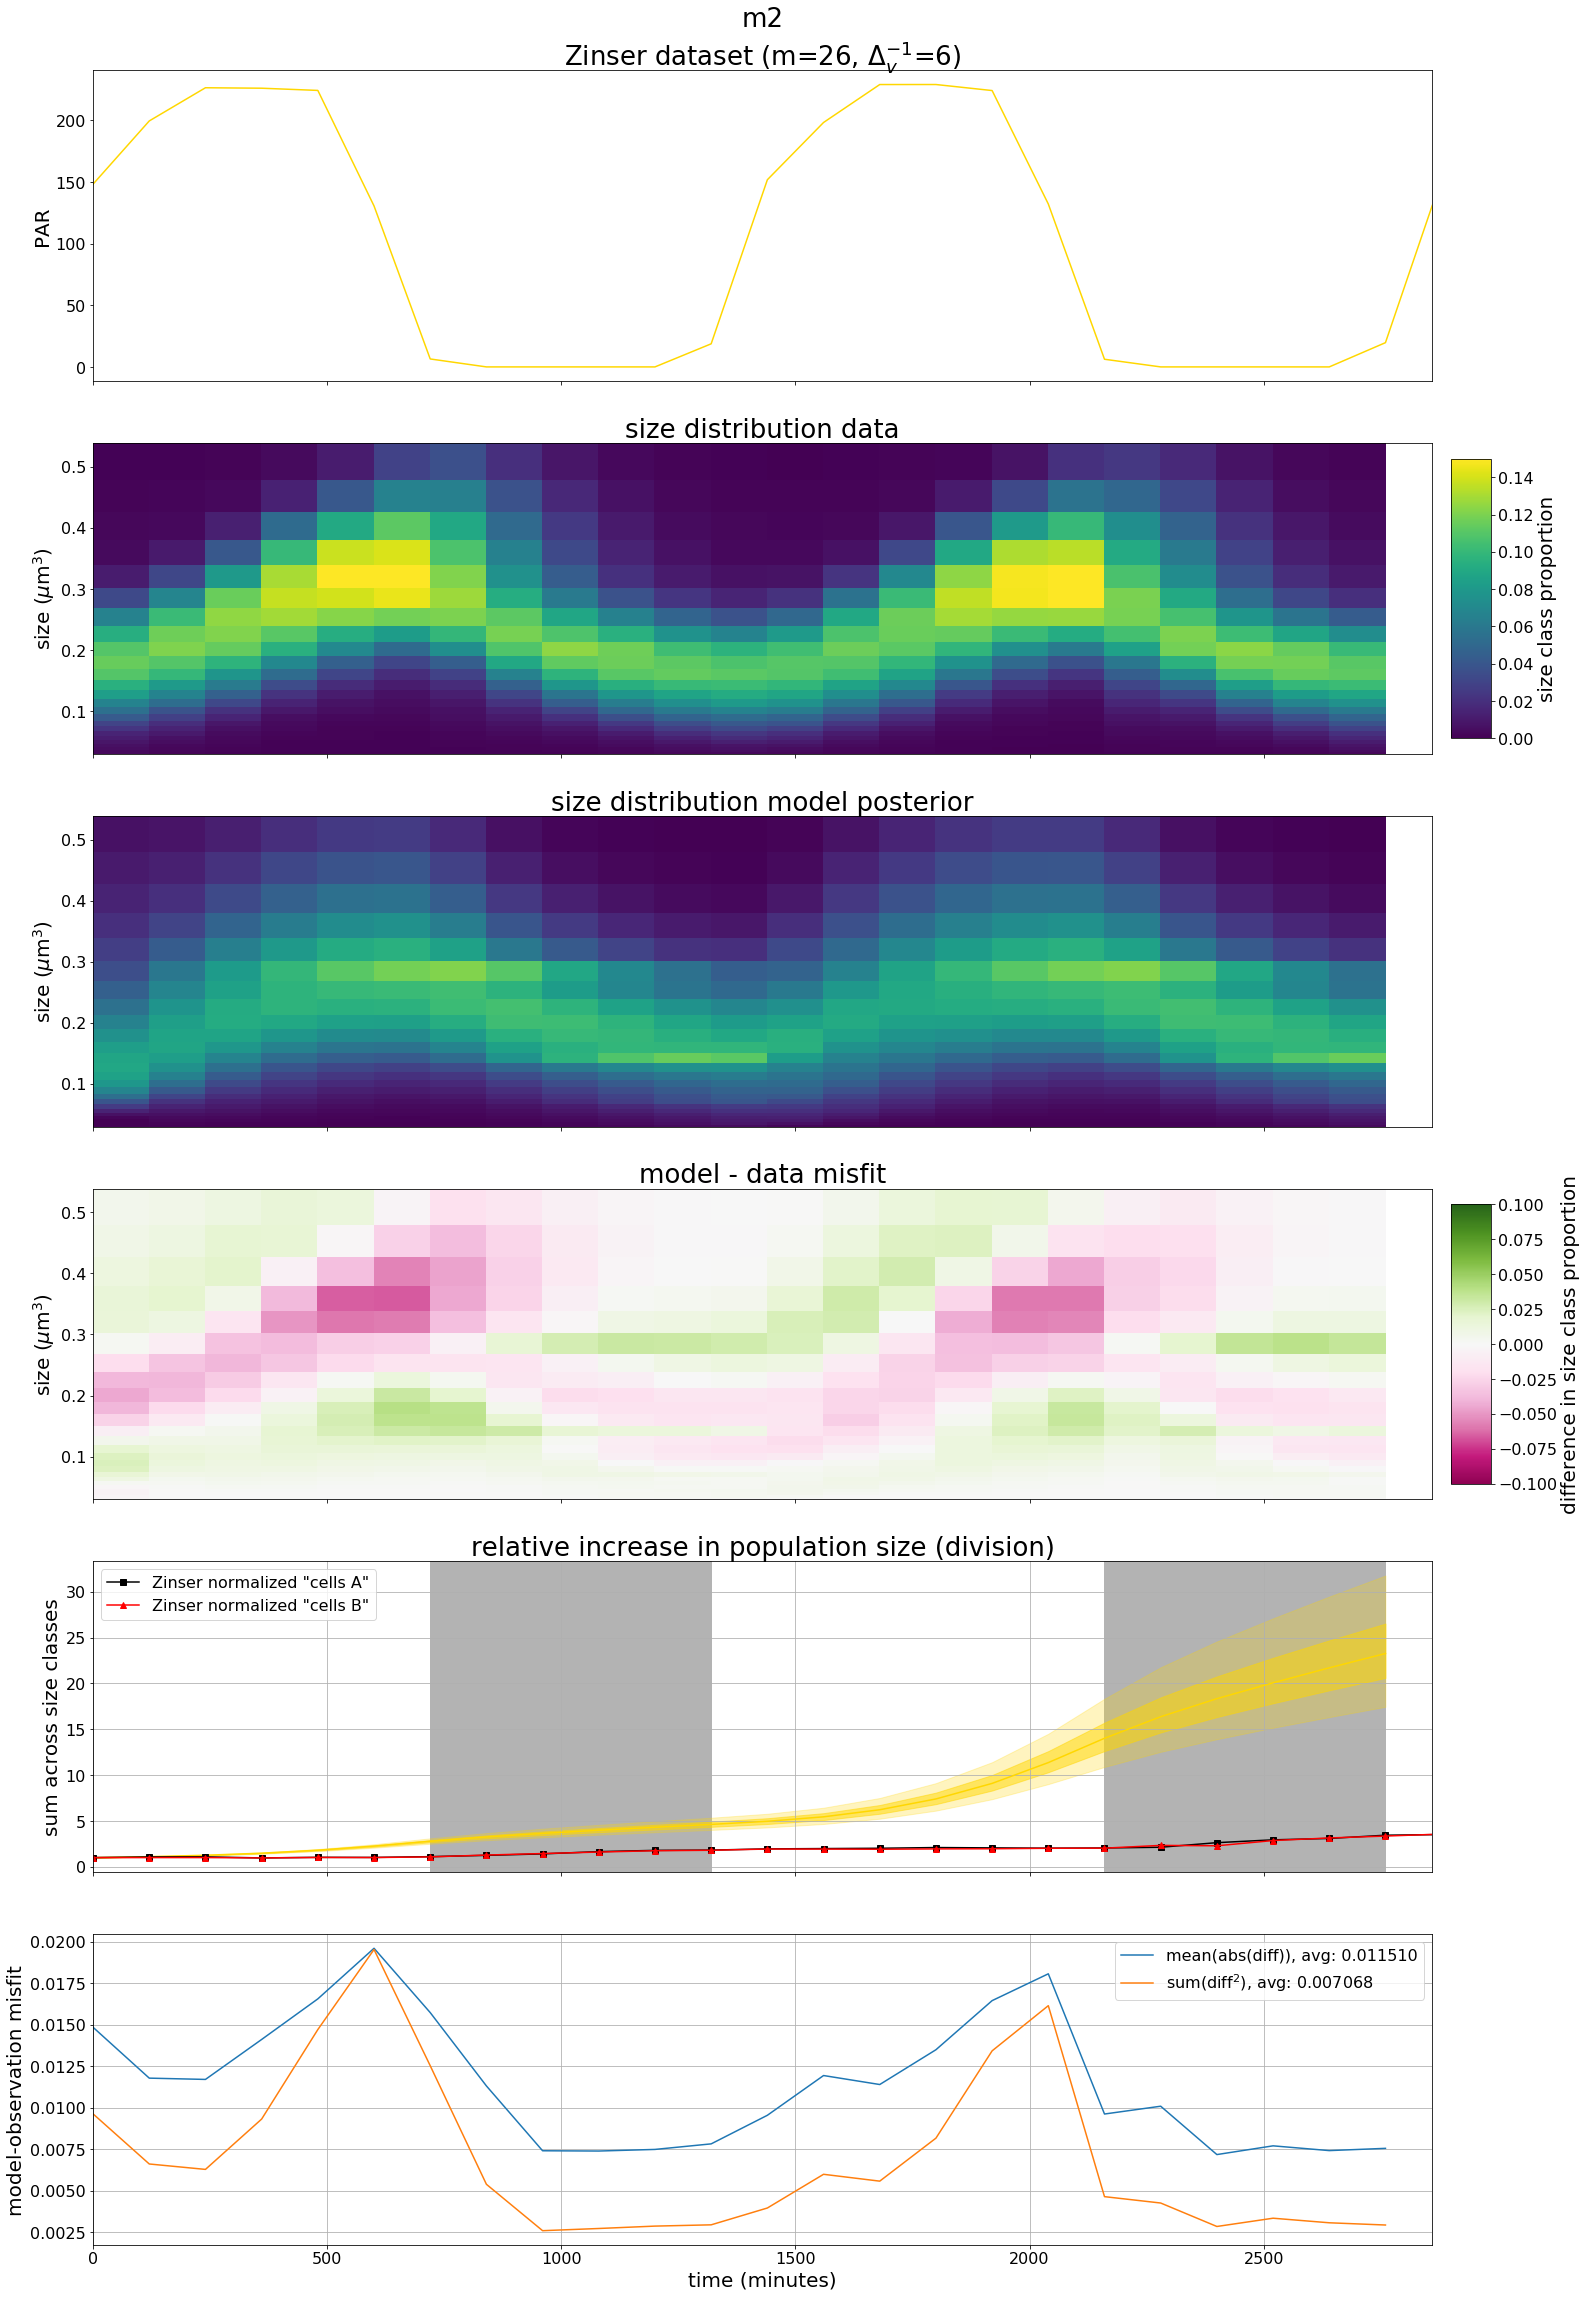

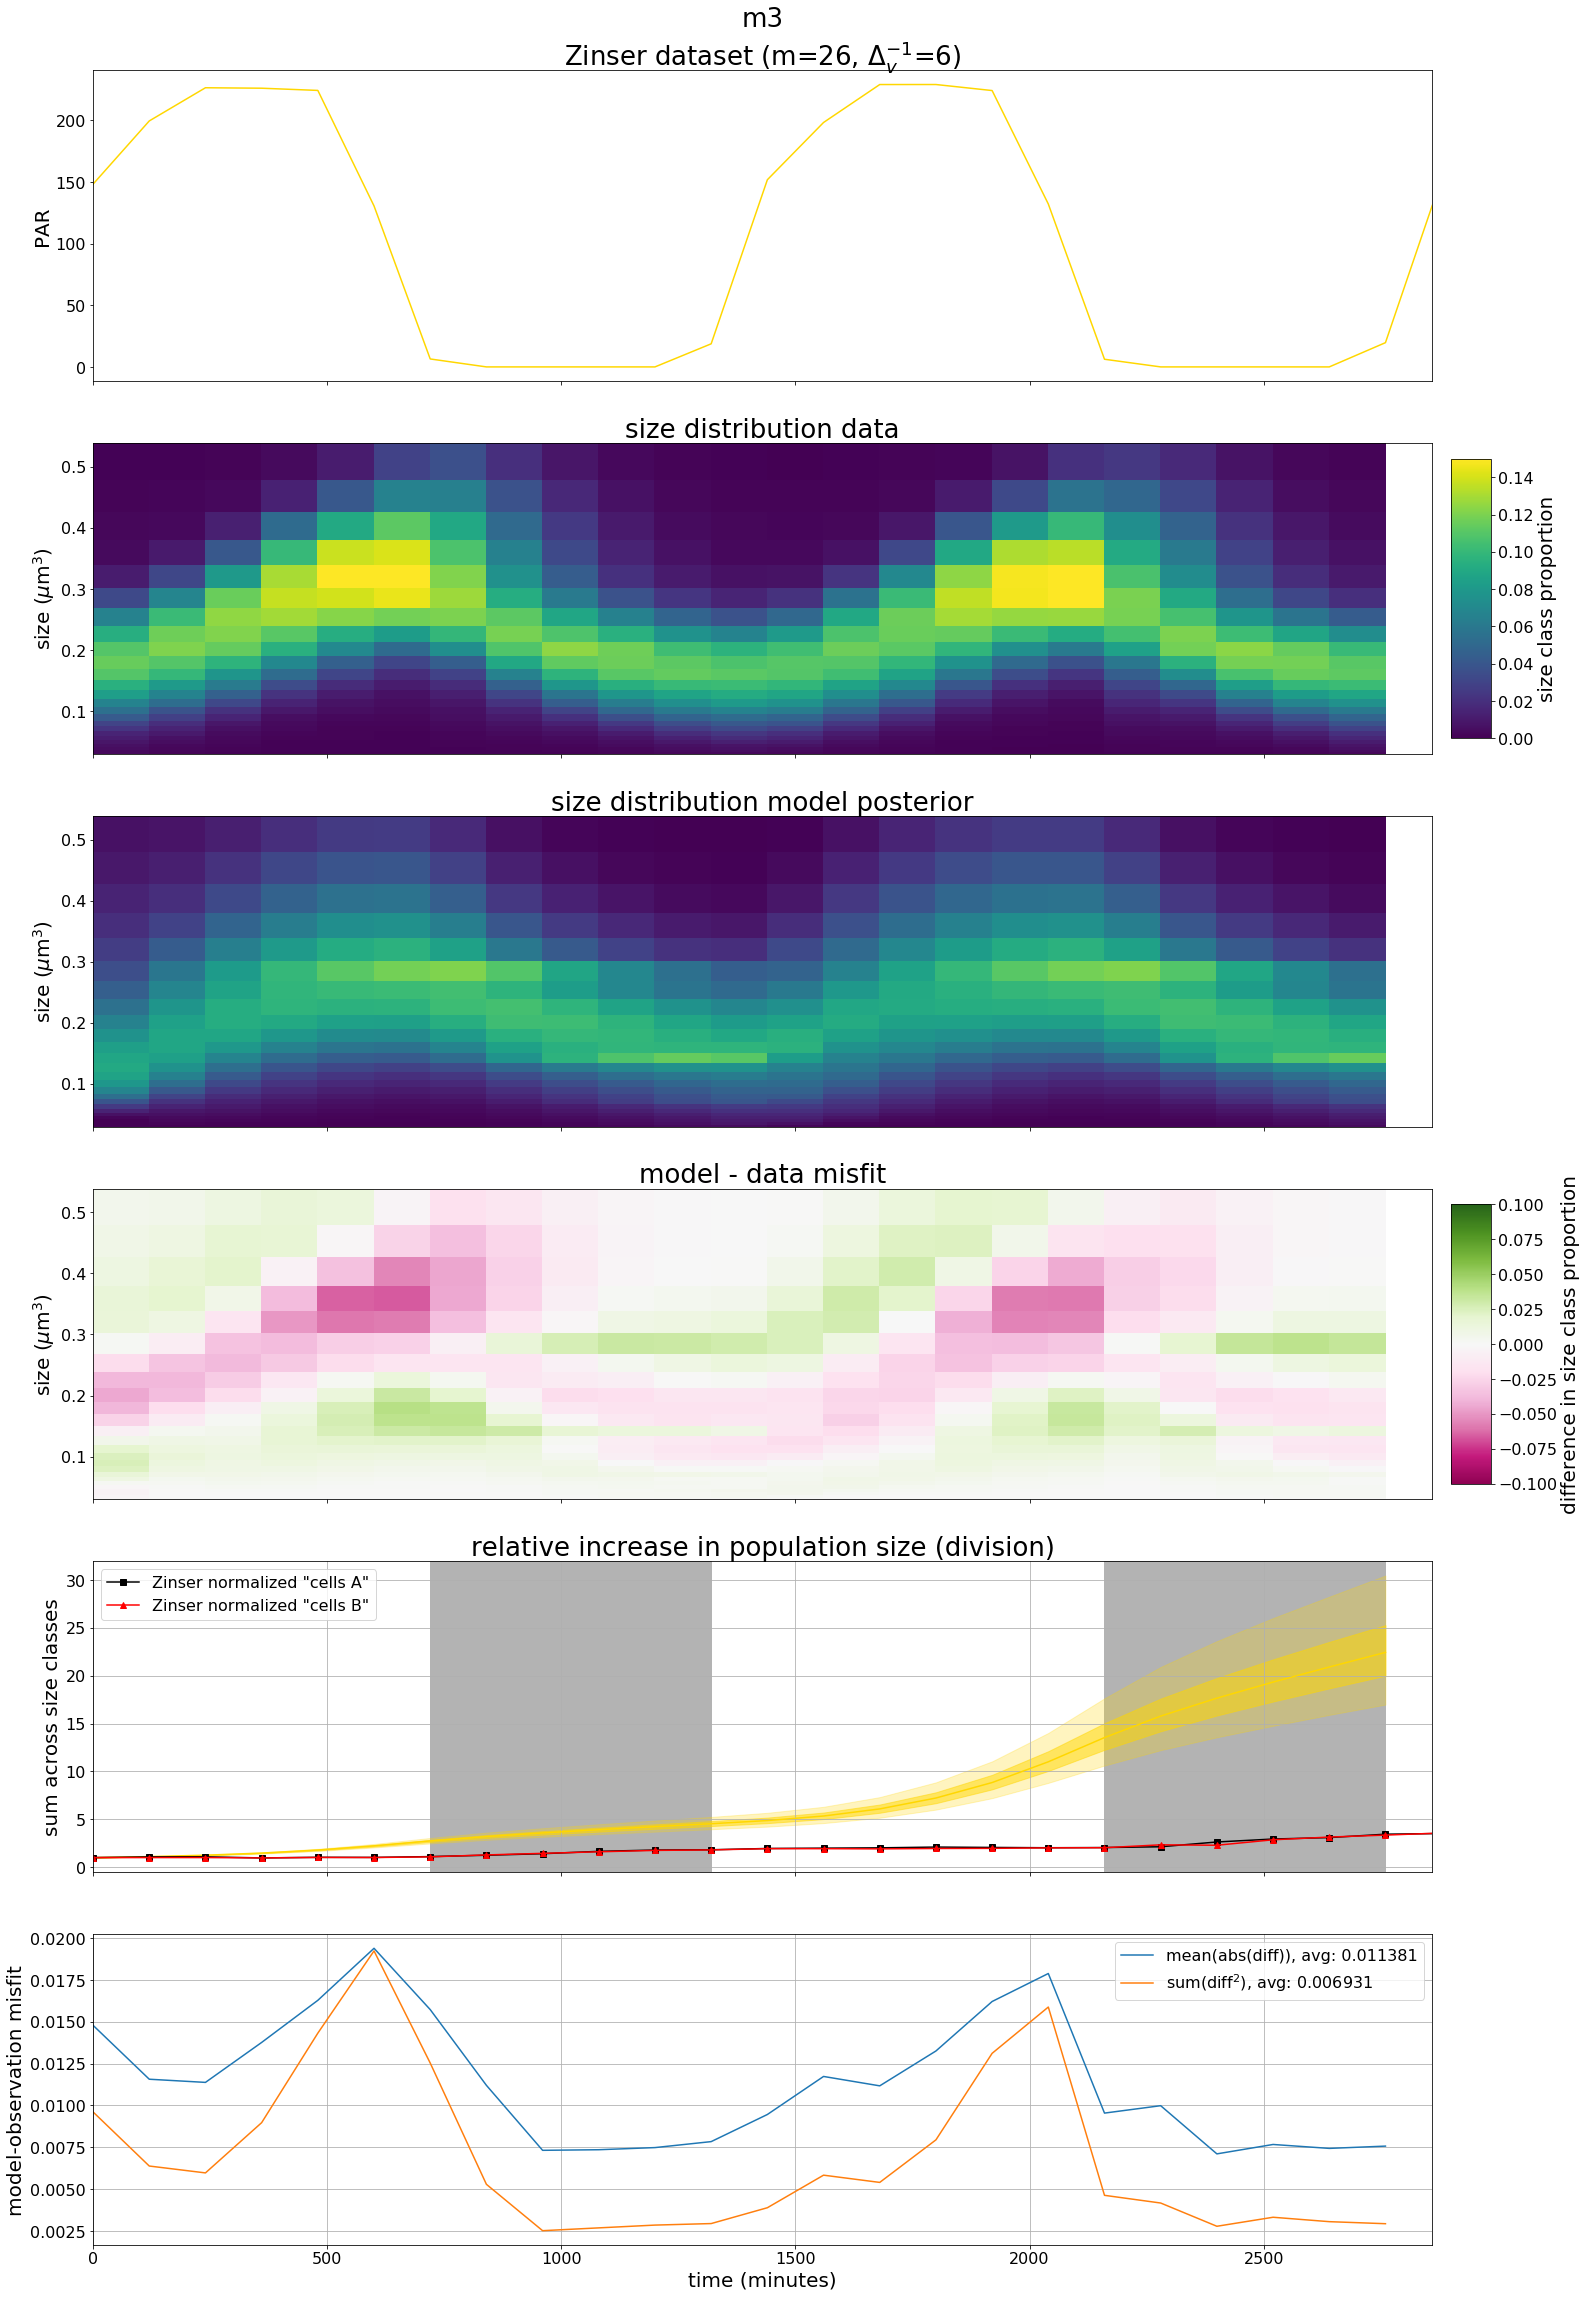

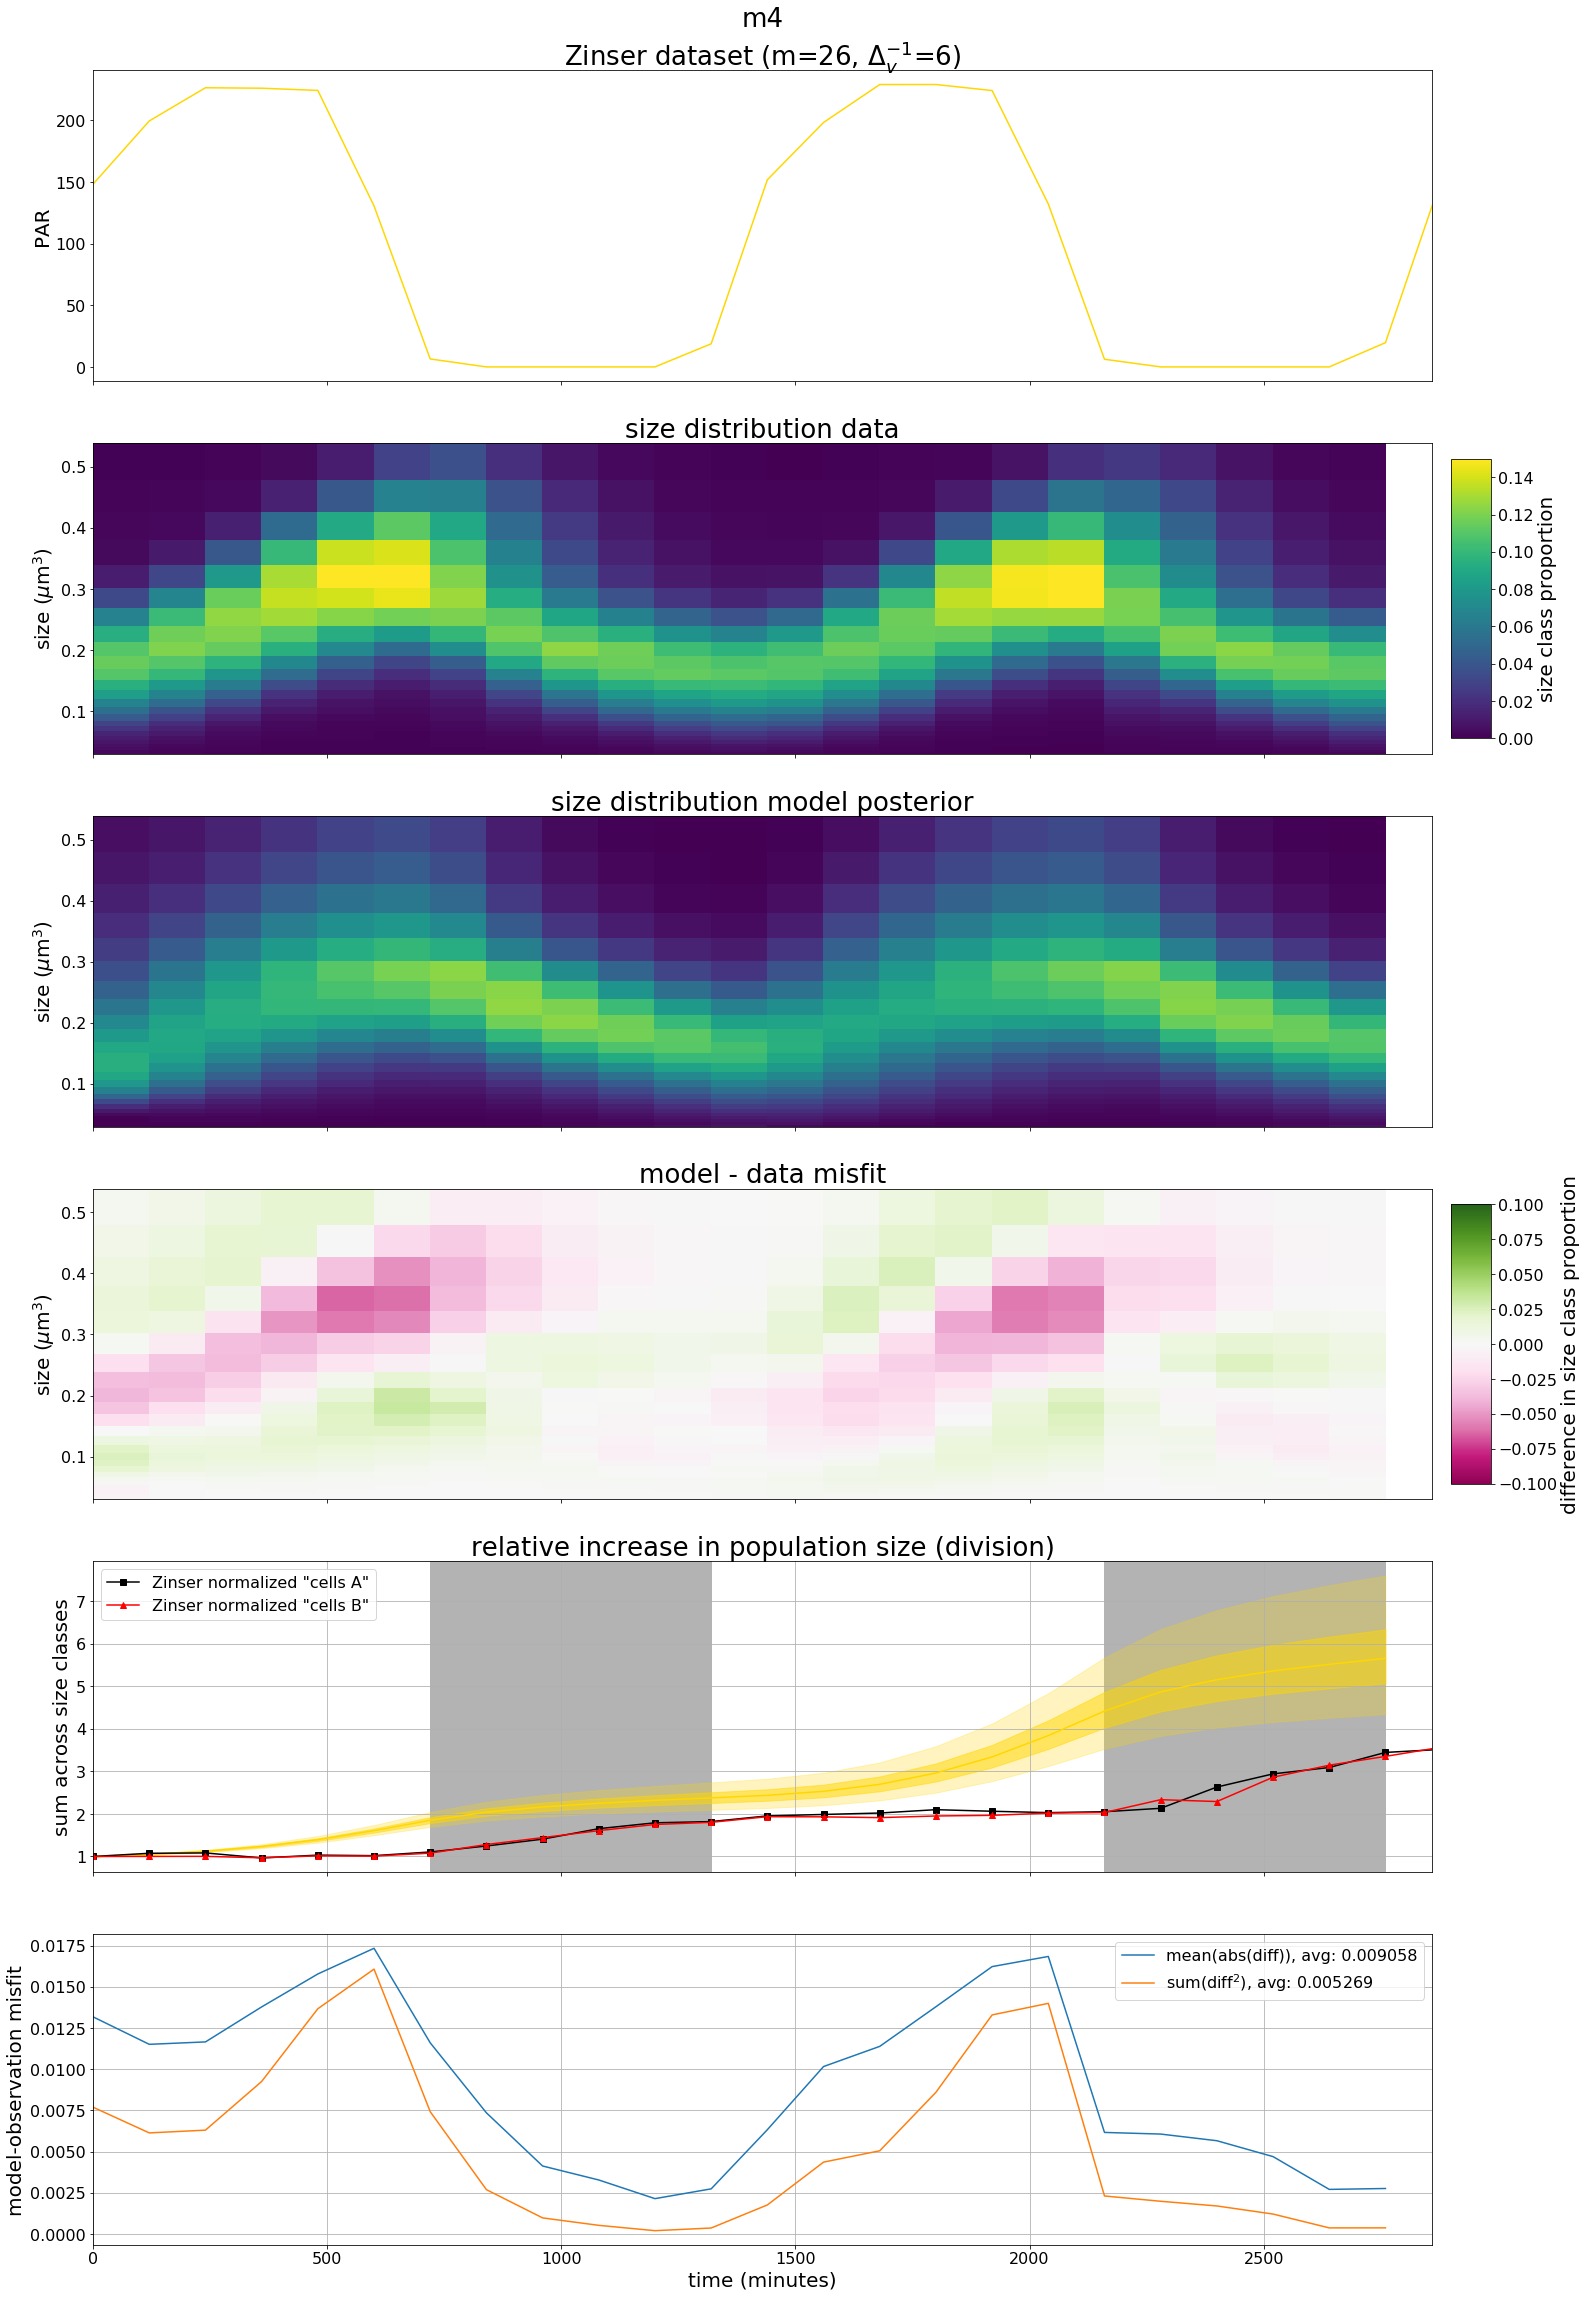

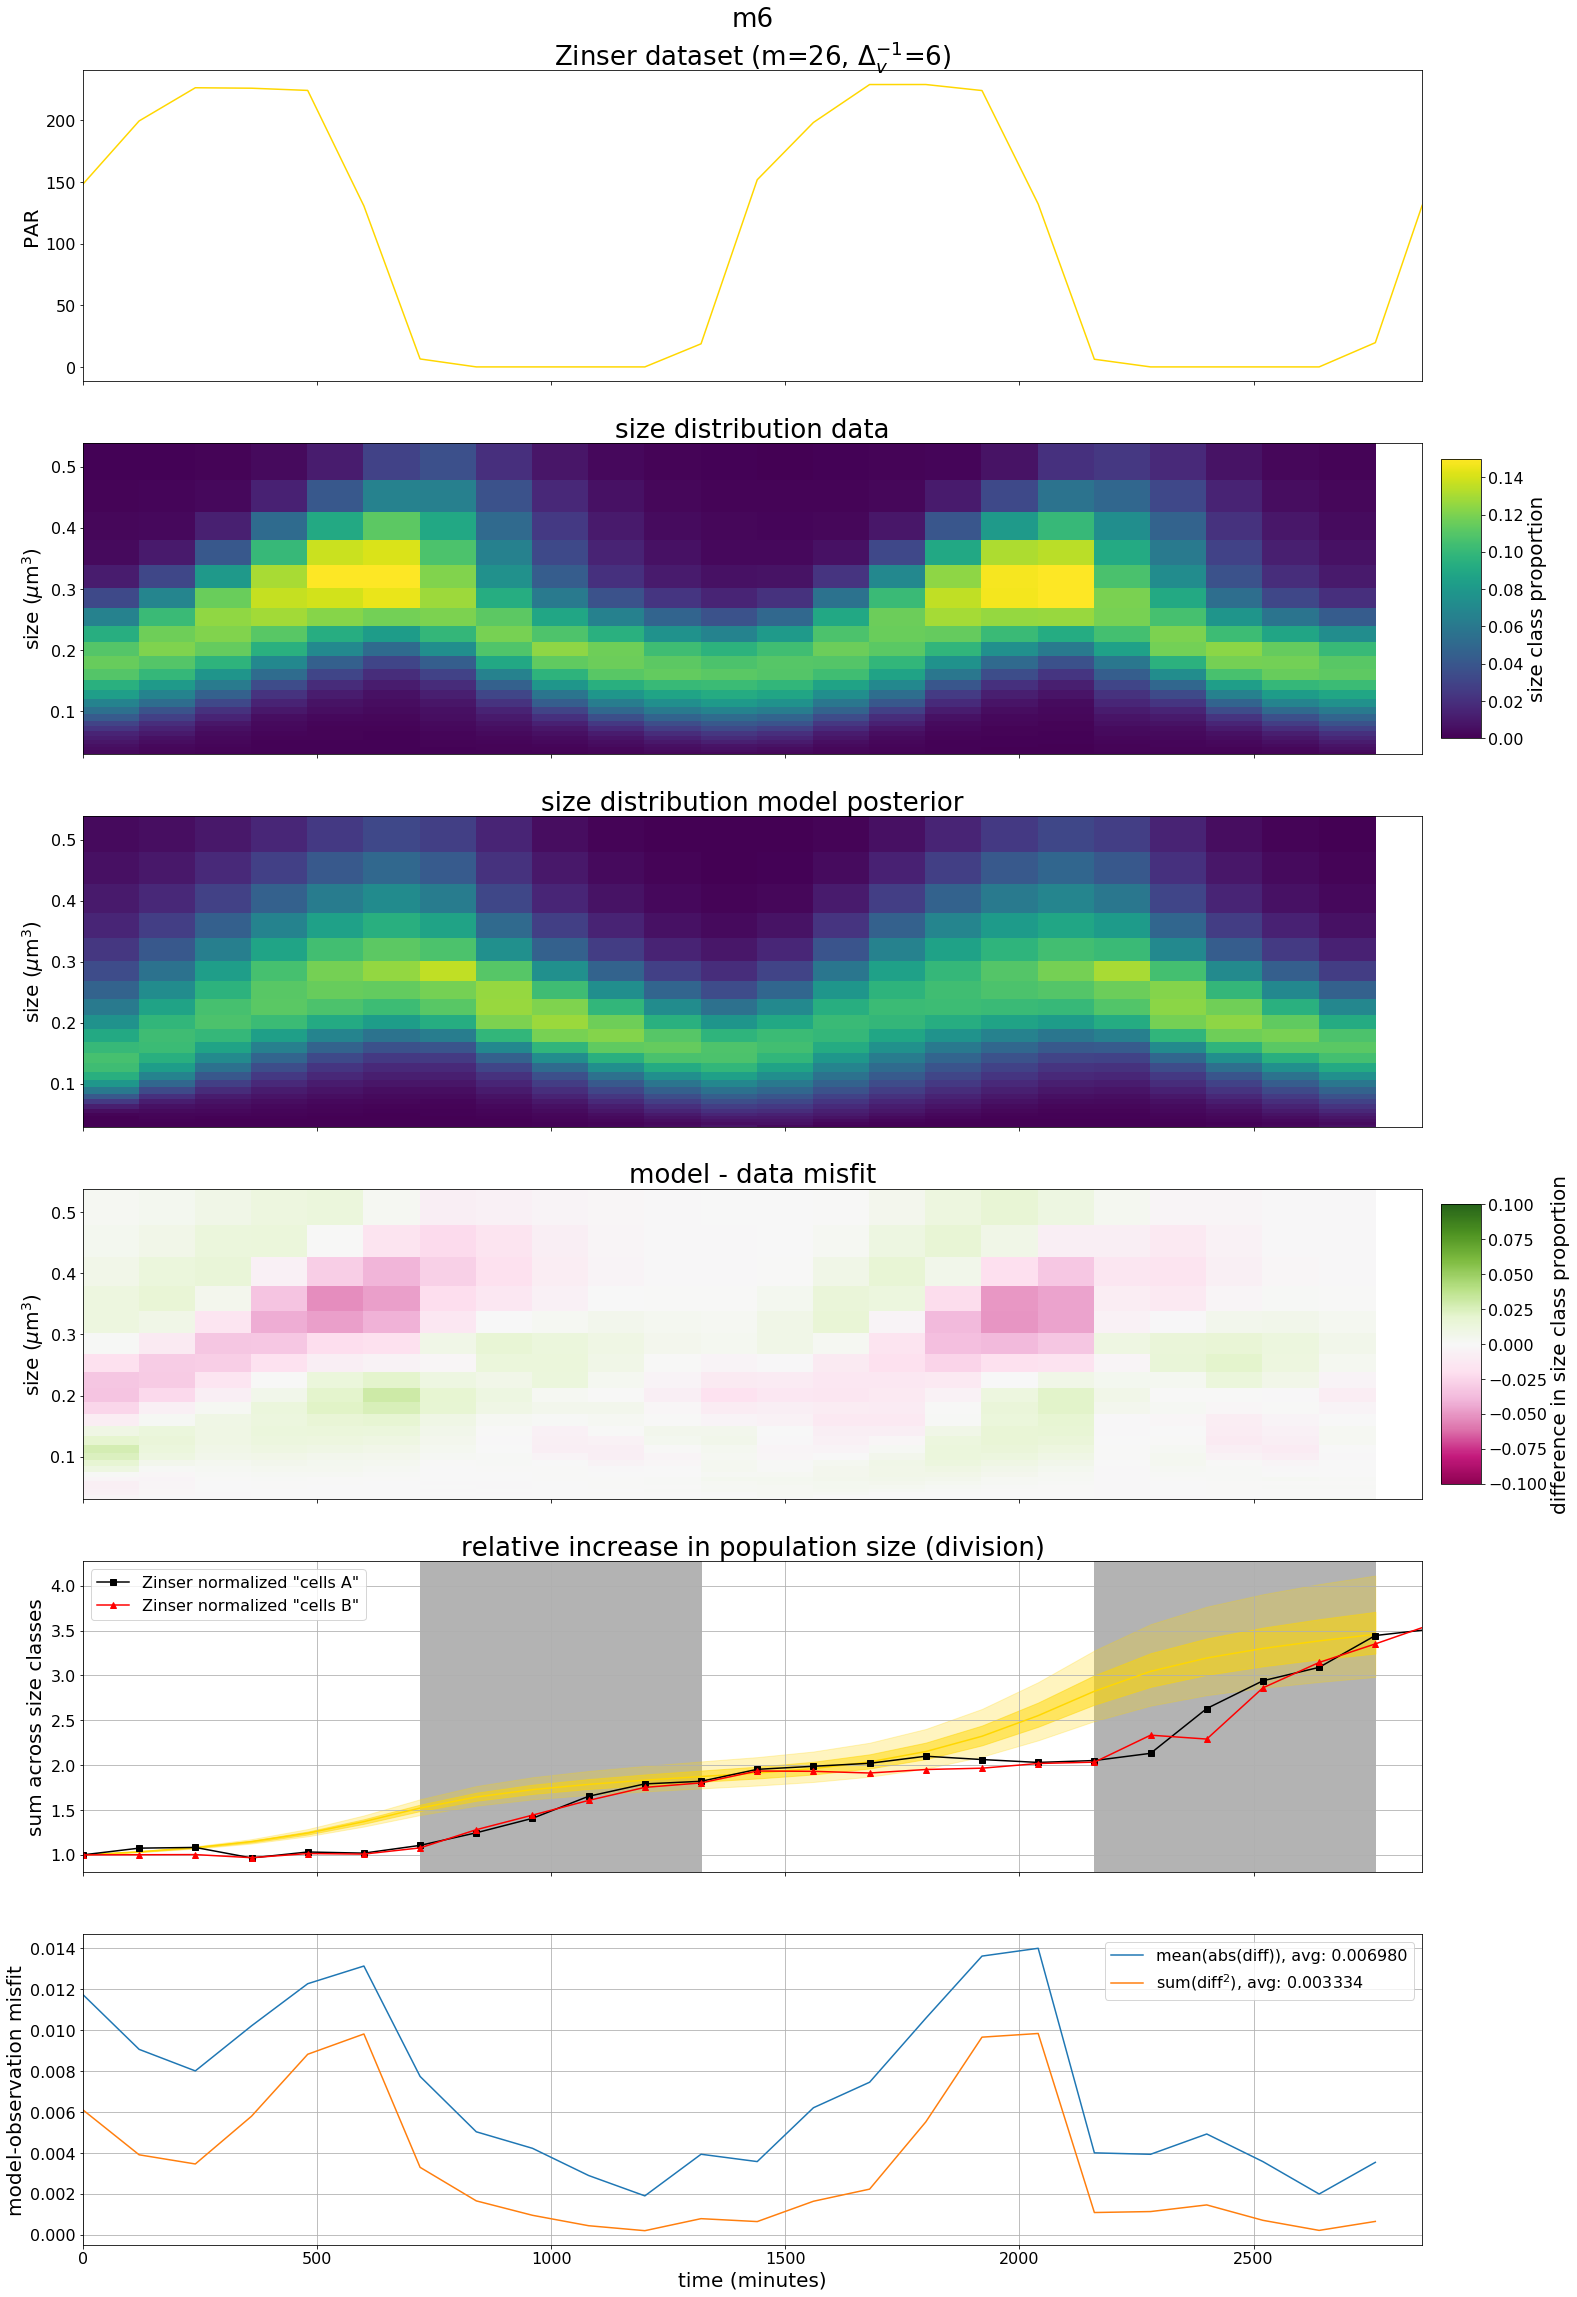

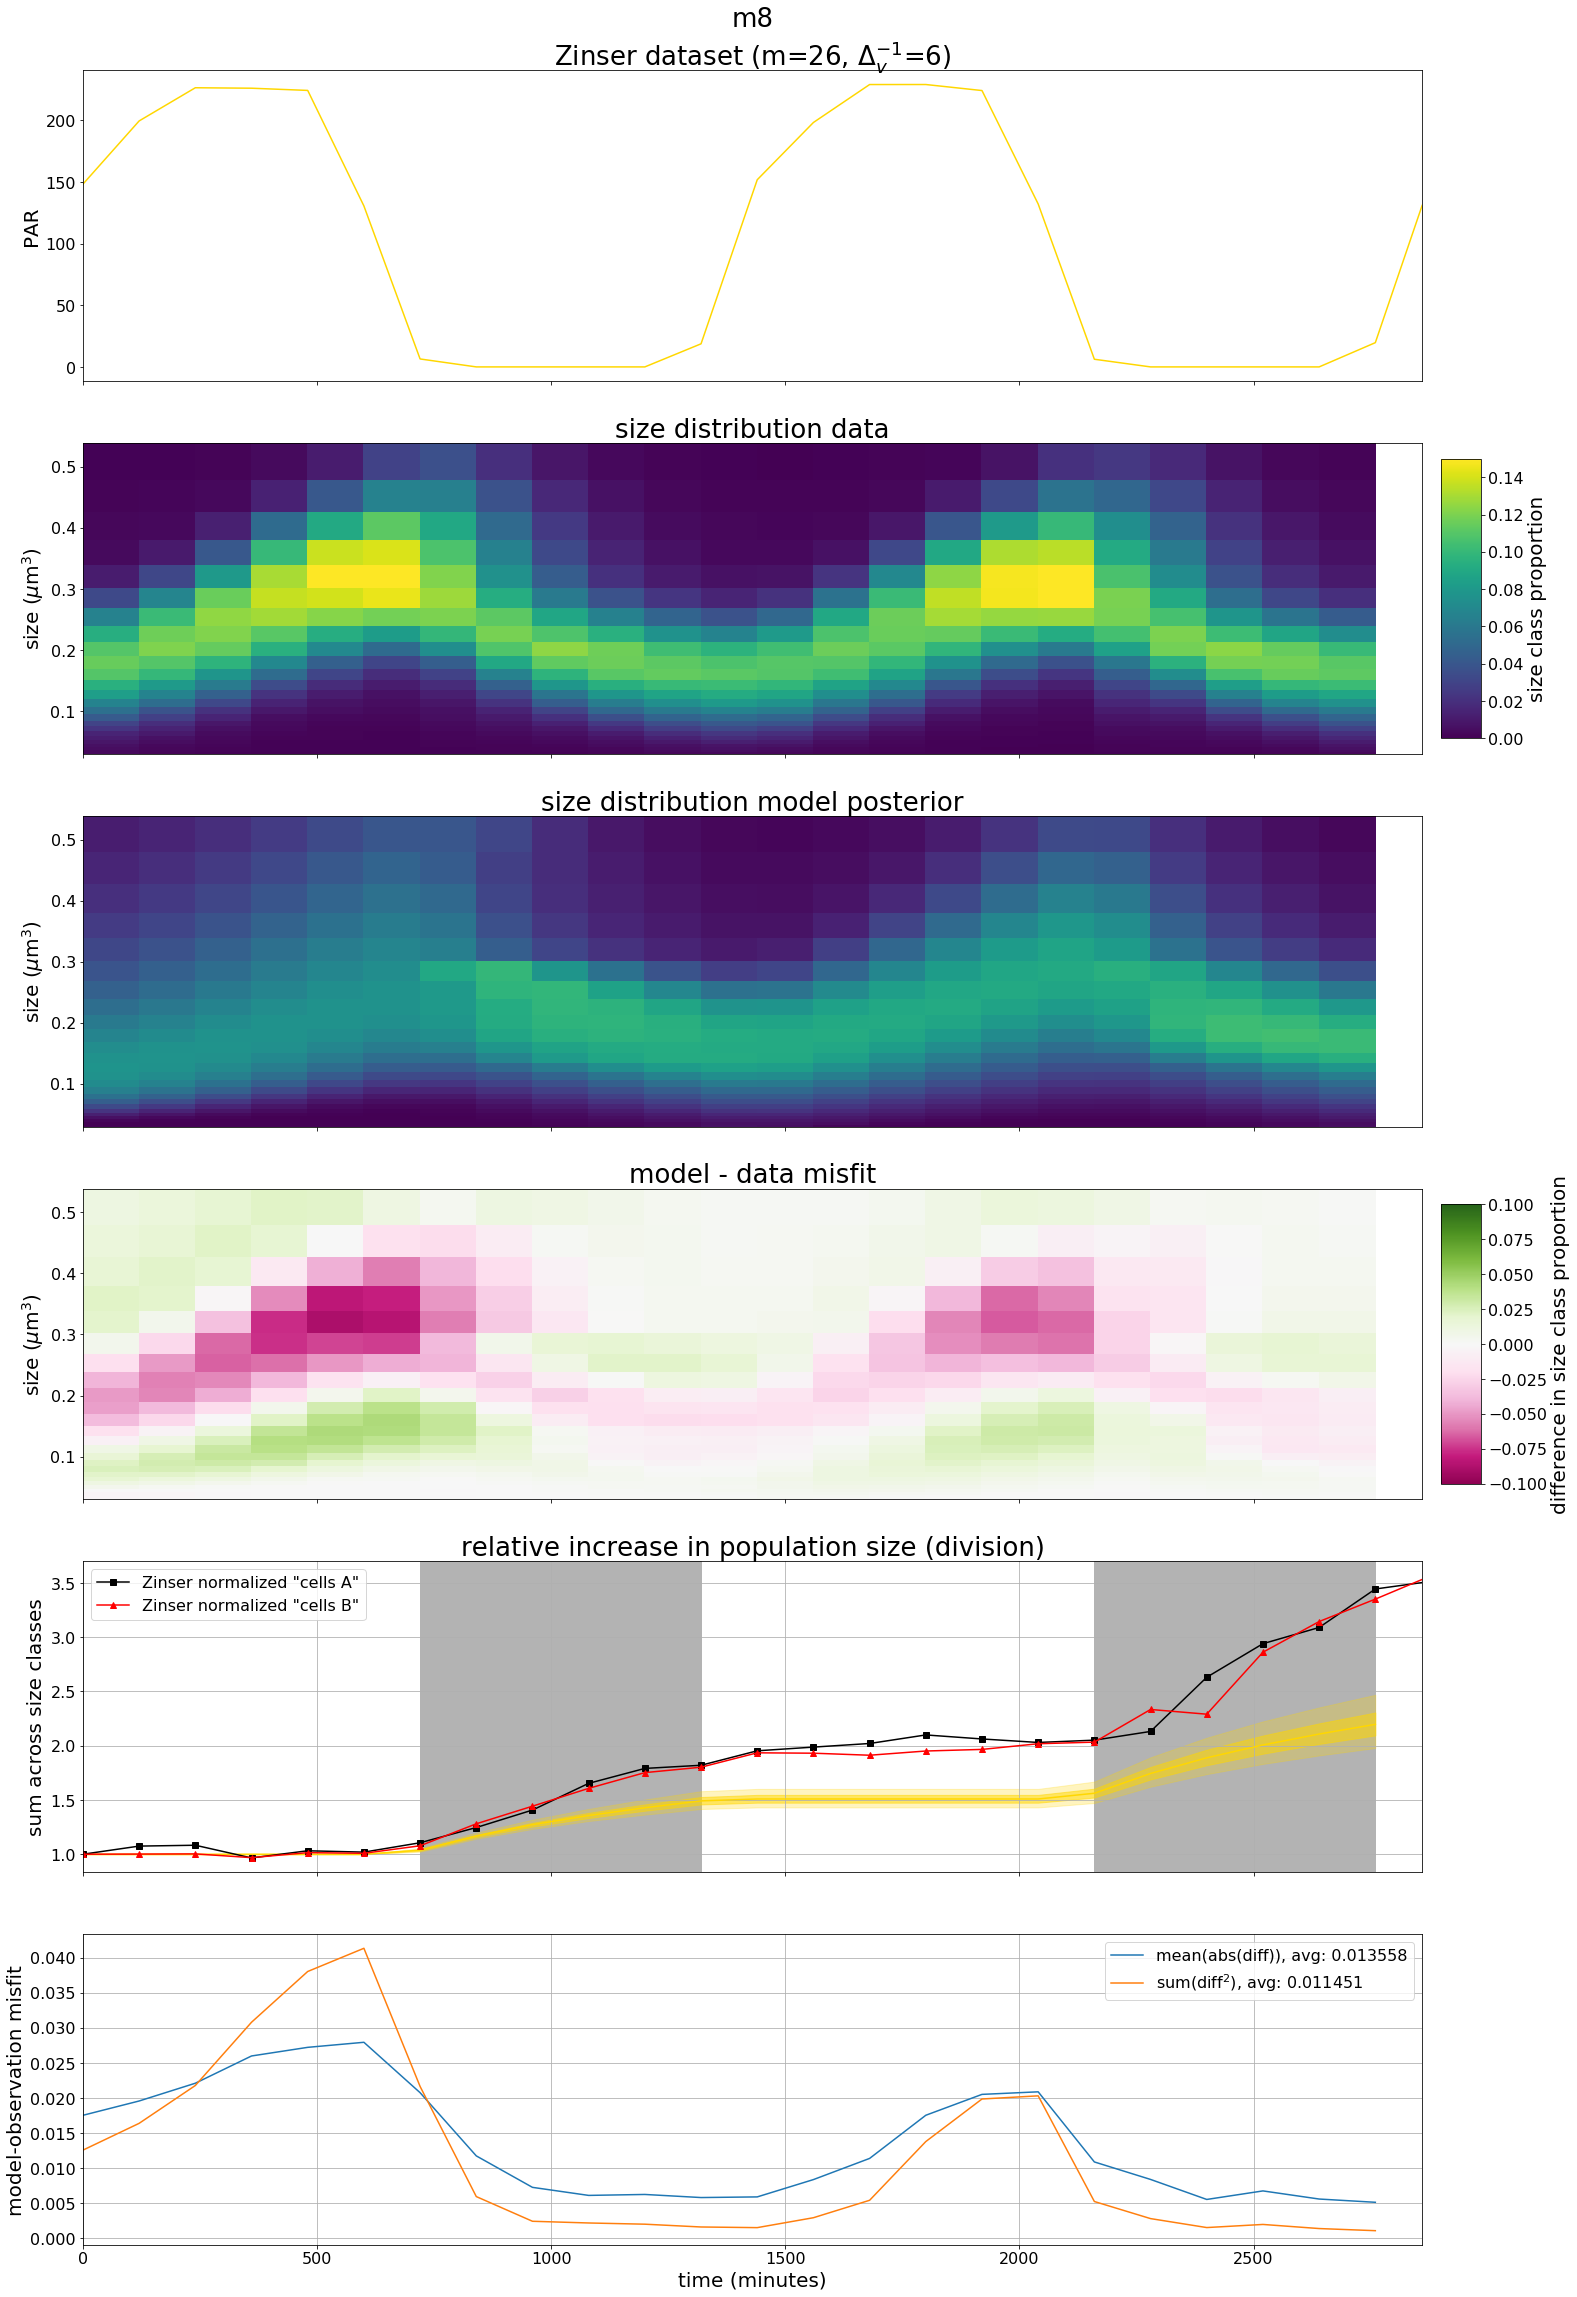

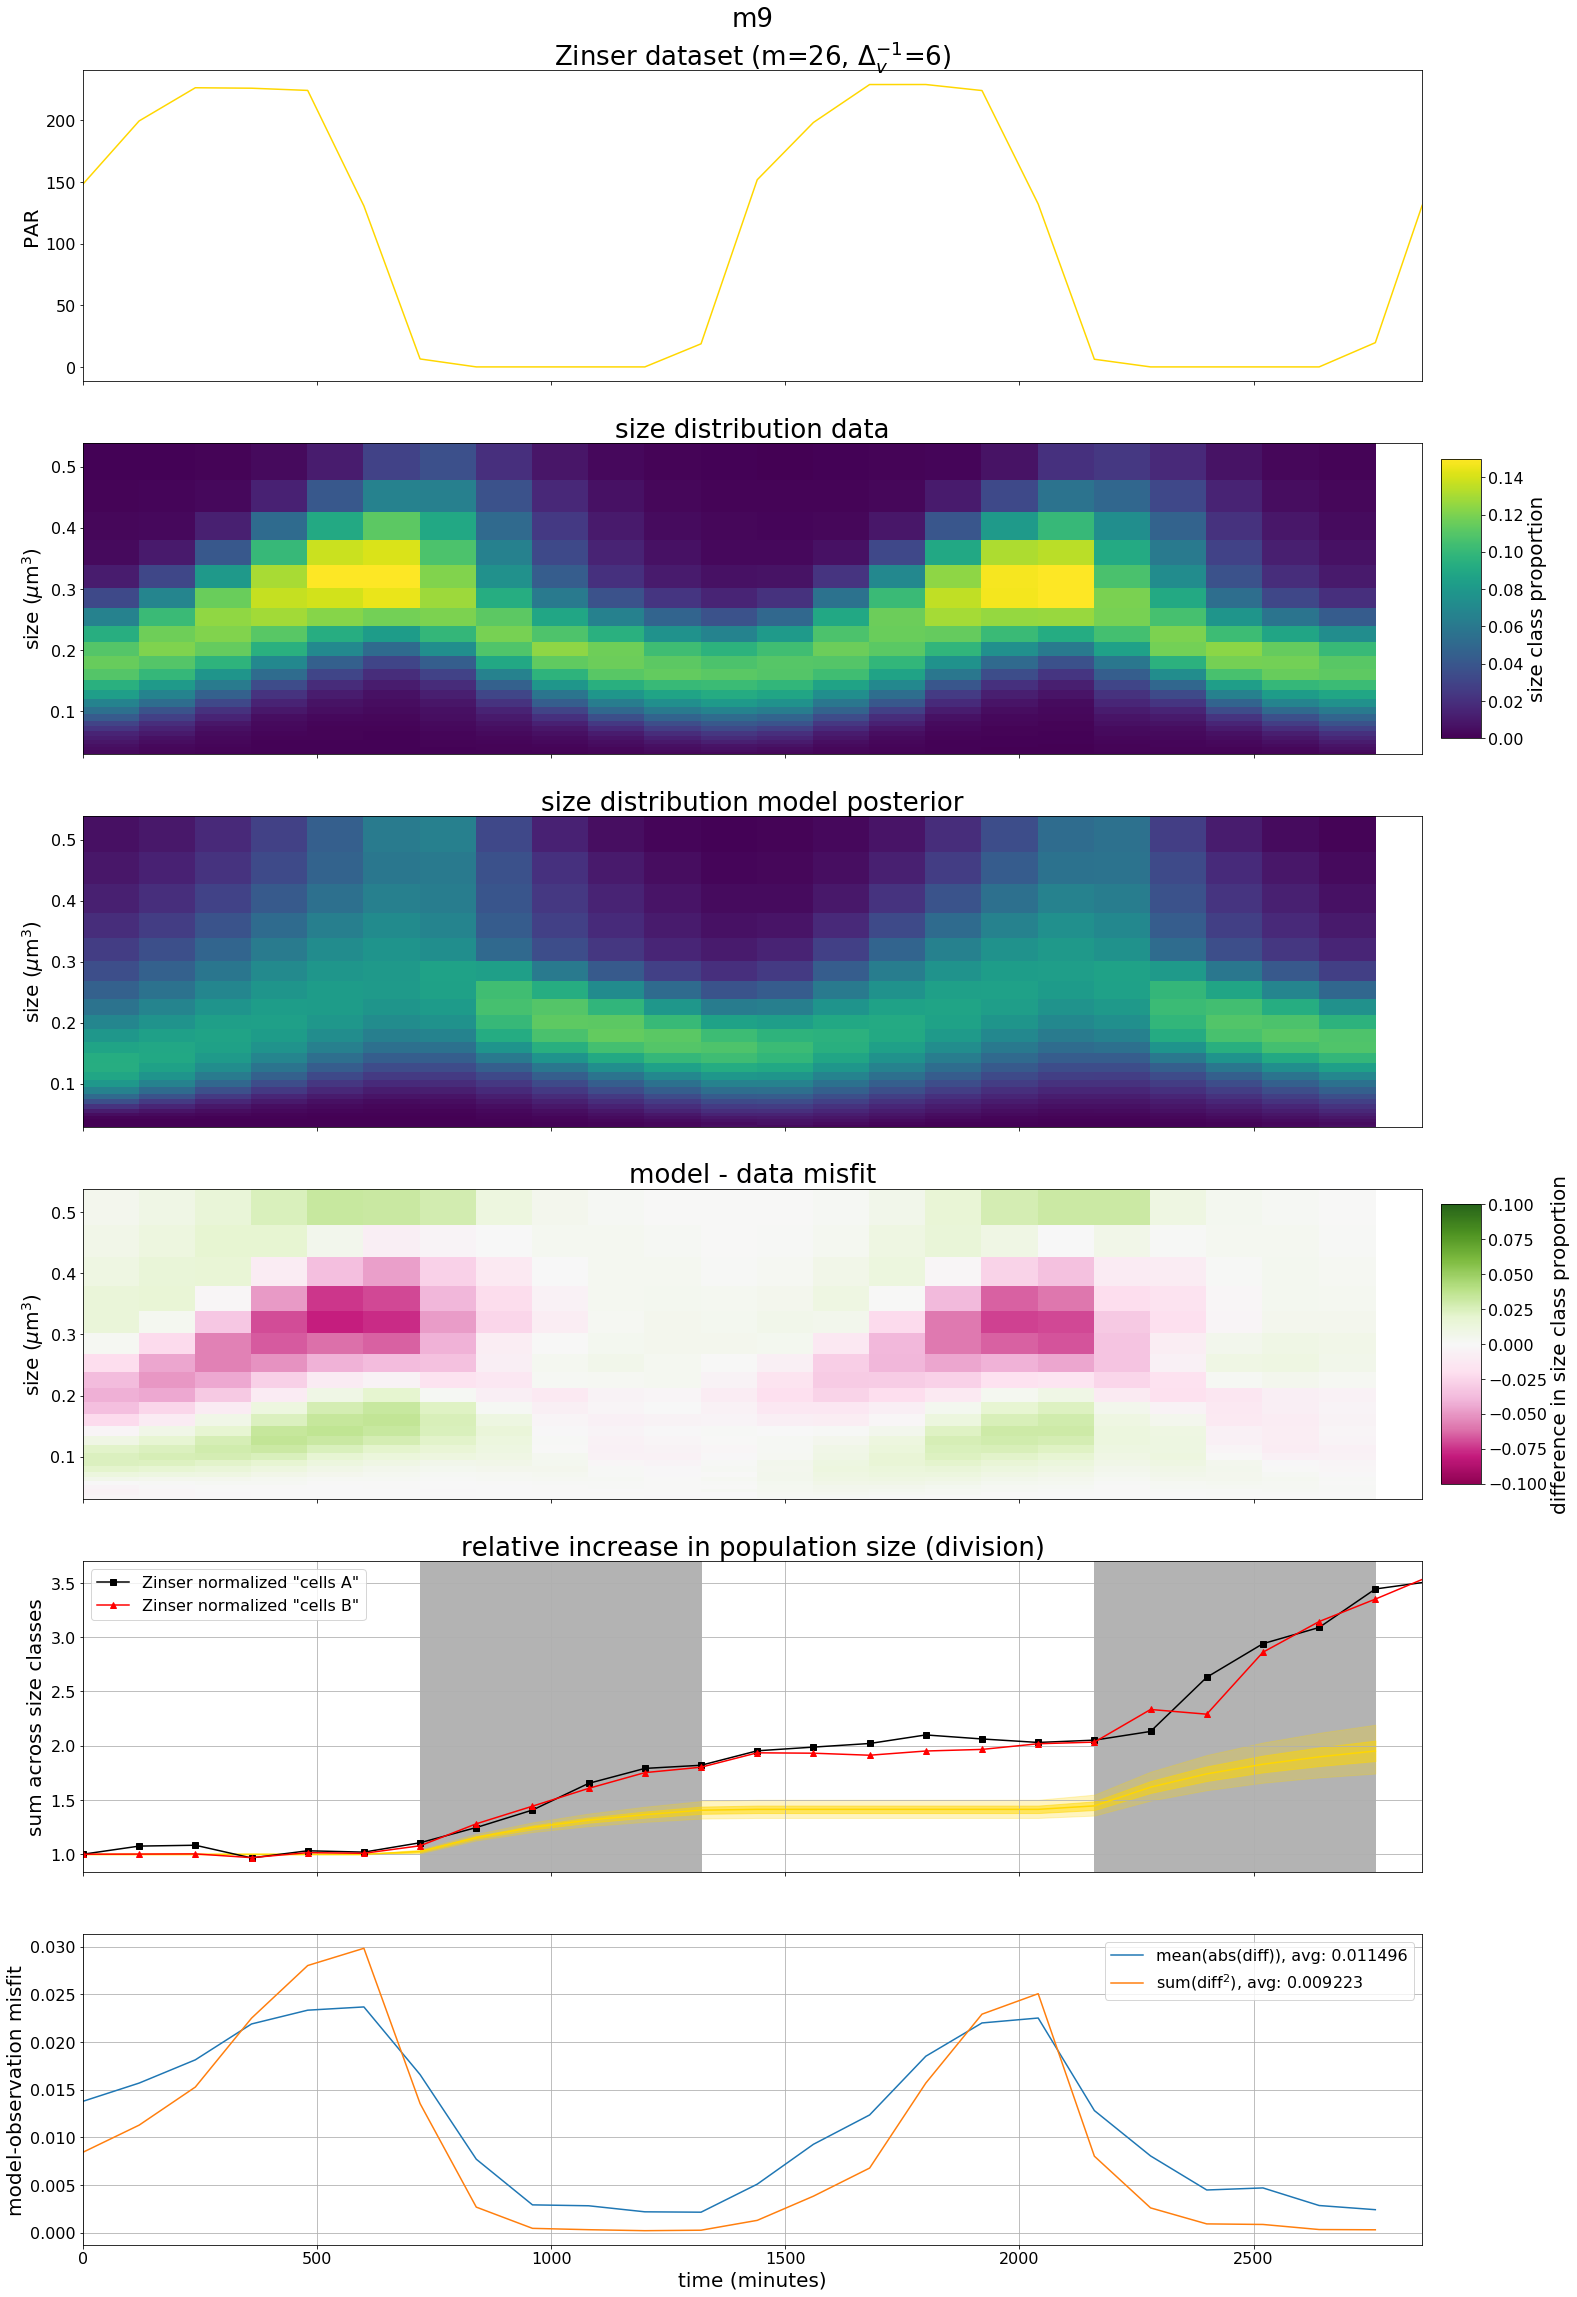

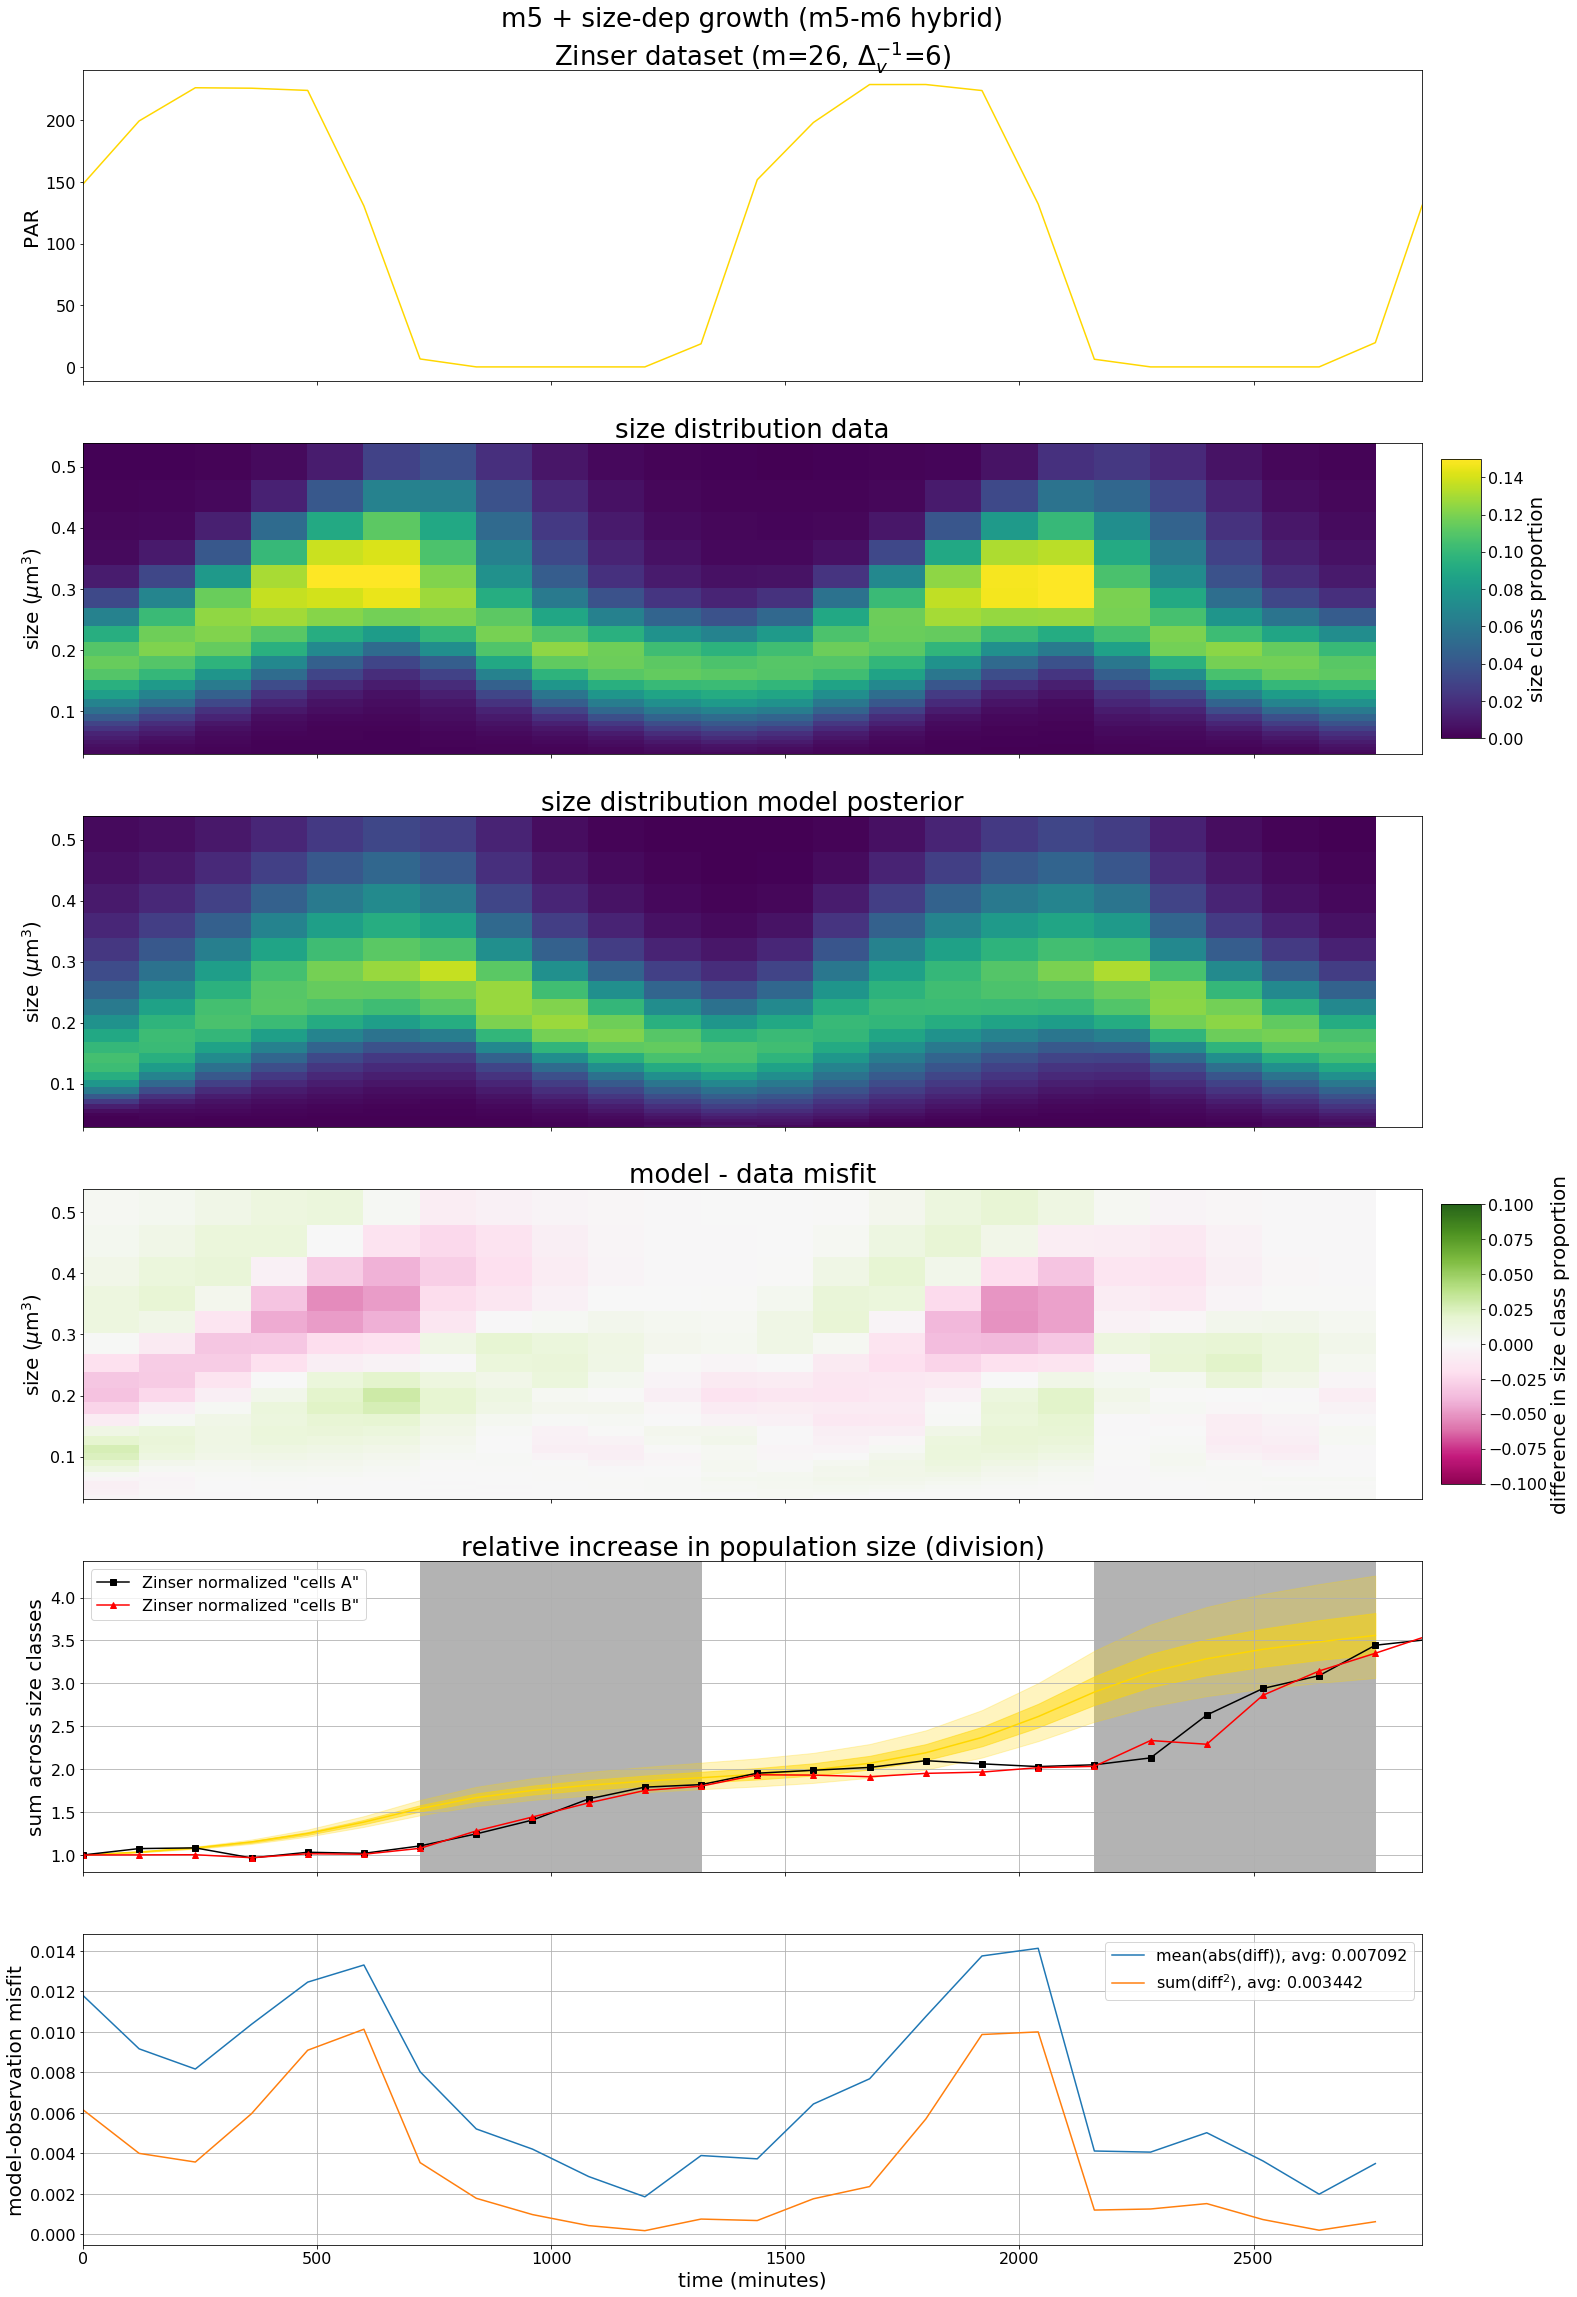

In [12]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

## a few new preliminary plots

In [13]:
# save data for plotting

import netCDF4 as nc4

for dataname in data:

    ncname = 'data_experimental_zinser_seaflow_20200603_gallery1_test2_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,name in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[name][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[name][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[name][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[name][dataname][v]

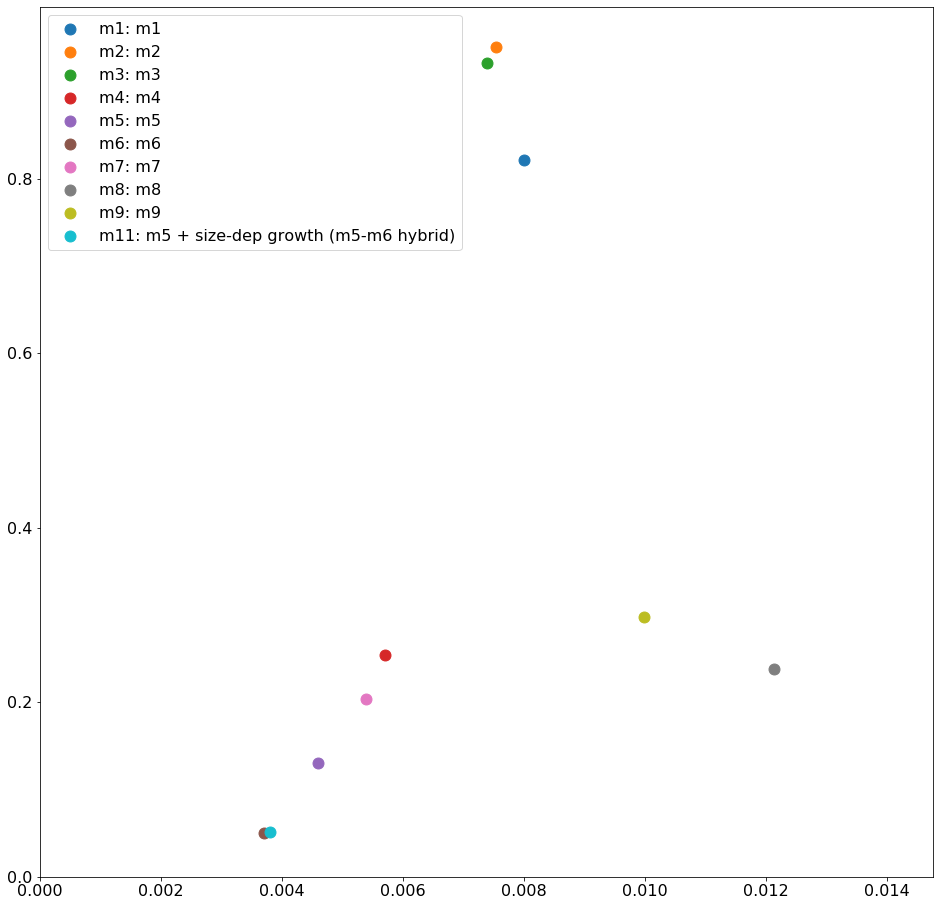

In [14]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.63}}

model_shortname = {name:name.replace('s','m') for name in mcmcs}

height = np.zeros(3)
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(16,16))

        for name in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2

            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            # misfit to division rate

            e1 = np.sqrt(np.mean((mcmcs[name][dataname]['divrate'] - reference_values[dataname]['divrate'])**2))
        
            ax.scatter(np.mean(e0), np.mean(e1), label=model_shortname[name]+': '+desc_model[name], s=120)
        
        ax.legend()
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)
        '''
        xticks = []
        xticklabels = []
        for i,name in enumerate(mcmcs):
            

        if ax.get_ylim()[1] > 0.005:
            ax.set_ylim(top=0.005)
        ax.set(ylabel='sum of squared column differences', xticks=xticks)
        ax.set_title('model misfit for '+desc[dataname], size=20)
        ax.set_xticklabels(xticklabels)#, rotation=8)
        ax.grid(axis='y')
        '''

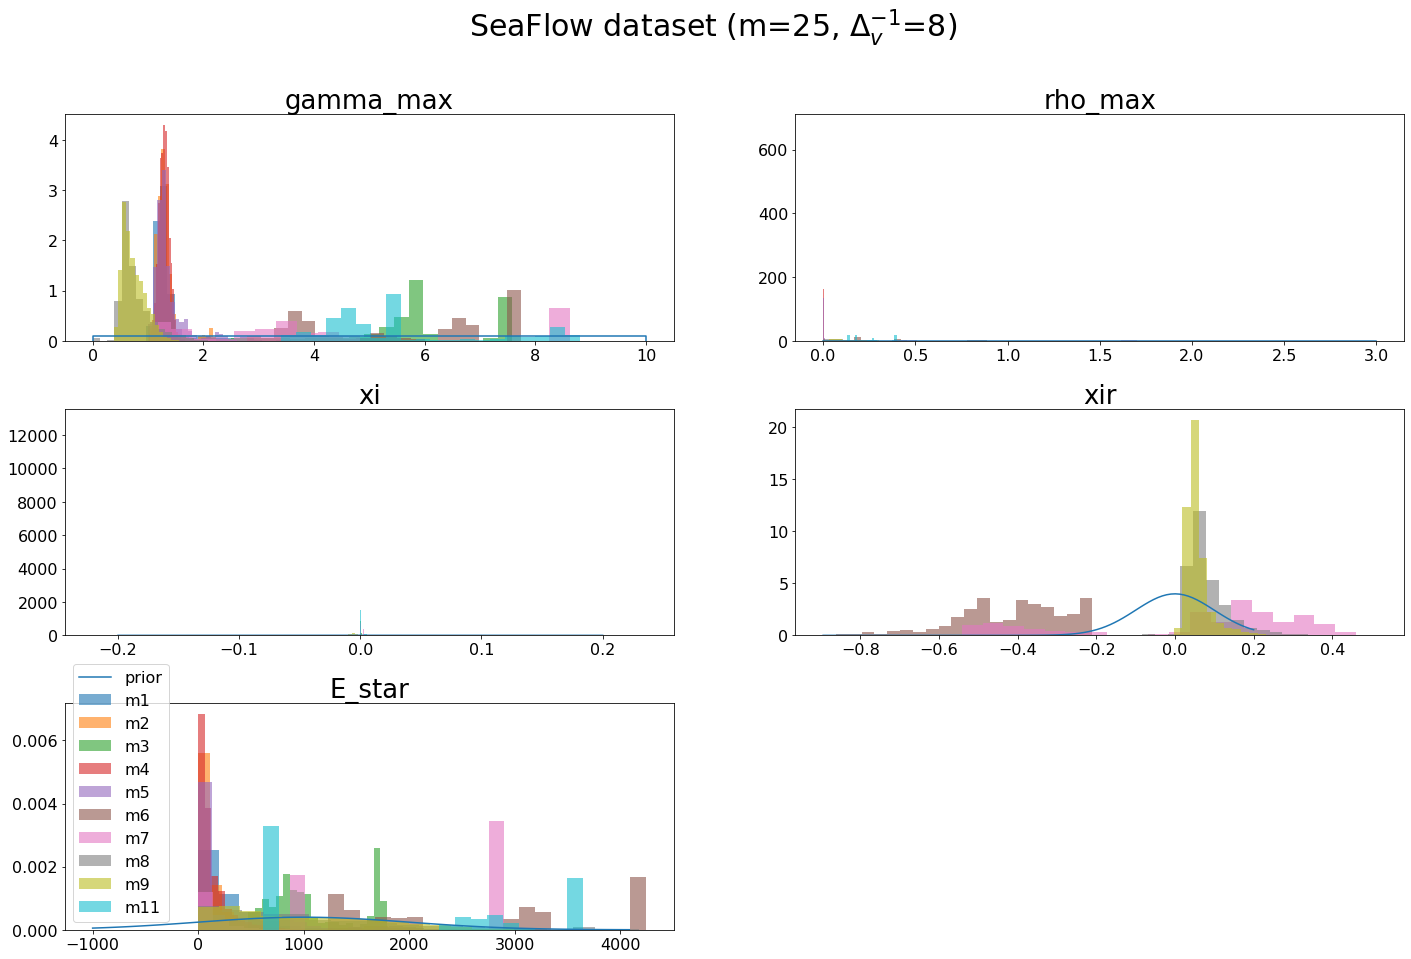

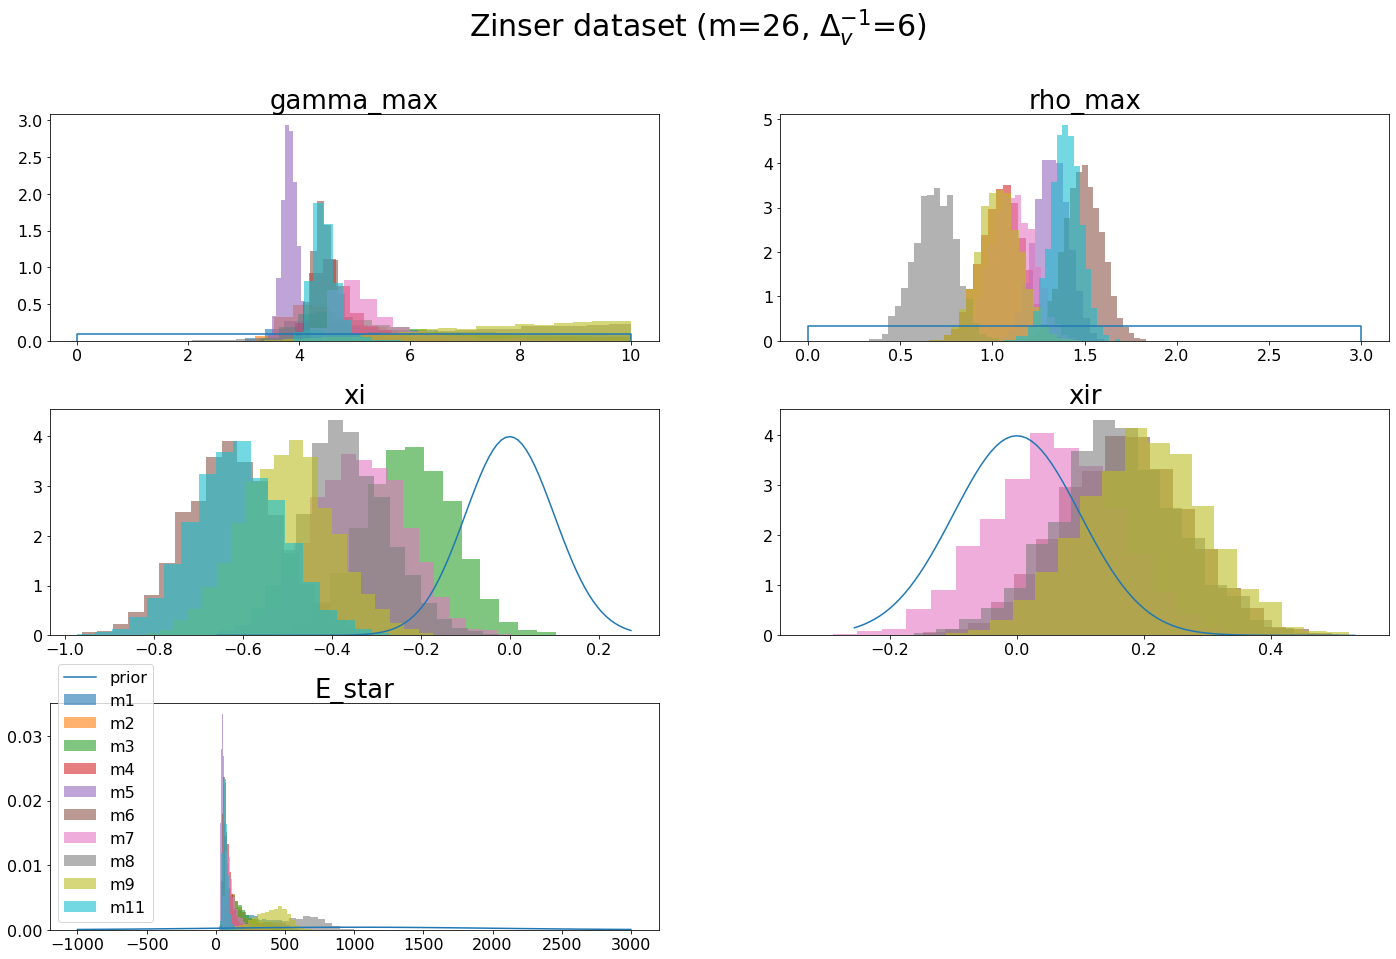

In [15]:
# plotinfo contains information about the prior distribution and the reference value of 
# the parameters and initial conditions used for plotting. If these are changed in the 
# code above, change them here as well. 
plotinfo = {
    'gamma_max':{'priordist':'uniform', 'priorparams':(0.0,10.0), 'refvalue':None},
    'rho_max':{'priordist':'uniform', 'priorparams':(0.0,3.0), 'refvalue':None},
    'xi':{'priordist':'normal', 'priorparams':(0.0,0.1), 'refvalue':None},
    'xir':{'priordist':'normal', 'priorparams':(0.0,0.1), 'refvalue':None},
    'E_star':{'priordist':'normal', 'priorparams':(1000.0,1000.0), 'refvalue':None},
}

import scipy.stats as stats

ncols = 2
nrows = int(np.ceil(len(plotinfo)/ncols))
for dataname in data:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 5*nrows), gridspec_kw={'hspace':0.3})
    fig.suptitle(desc[dataname], size=30)
    for ax in axs.flat:
        ax.set_visible(False)
    for ax,paramname in zip(axs.flat, plotinfo):
        ax.set_visible(True)
        plotted_prior = False
        for imodel,name in enumerate(mcmcs):
            if paramname in mcmcs[name][dataname].flatnames:
                ax.hist(mcmcs[name][dataname][paramname], bins=20, density=True, color='C{}'.format(imodel), label=model_shortname[name], alpha=0.6)
                xlim = ax.get_xlim()
                if not plotted_prior and 'priordist' in plotinfo[paramname]:
                    plotted_prior = True
                    if plotinfo[paramname]['priordist'] == 'normal':
                        p = plotinfo[paramname]['priorparams']
                        x_min = min(p[0]-2*p[1], xlim[0])
                        x_max = max(p[0]+2*p[1], xlim[1])
                        x = np.linspace(x_min, x_max, 100)
                        ax.plot(x, stats.norm.pdf(x, loc=p[0], scale=p[1]), label='prior')
                    elif plotinfo[paramname]['priordist'] == 'uniform':
                        p = plotinfo[paramname]['priorparams']
                        y = 1.0/(p[1]-p[0])
                        ax.plot([p[0],p[0],p[1],p[1]], [0,y,y,0], label='prior')
            #ax.axvline(plotinfo[name]['refvalue'], color='darkred', label='reference value')
            ax.set(title=paramname)
    ax.legend()
None